Note: The background images are used as .png files for visualizing and plotting the tours. A local file path is given for those images and needs to be edited after the plot_visualization function. You need to save the png files and edit the path for the plotting. 

### Import Libraries

In [71]:
import time
st = time.time()

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
%matplotlib notebook
from scipy.spatial import distance
from scipy.spatial import distance_matrix
import math
import datetime
from itertools import combinations
from datetime import timedelta
from collections import defaultdict

Initializing the constants for speed and the capacities of the bus in each tour. 

In [73]:
speed = 60
detour = 1.4
capacity1 = 31
capacity2 = 54
capacity3 = 34
capacity4 = 31
capacity5 = 34
capacity6 = 31

Read the excel and save the tours as a dataframe. Please use the excel attached sent with this notebook as 'AOP2022_instance.v2.xlsx' file is manually modified and a column for school ID is being added for better handling the data.     
Renaming the columns as Student ID, Latitude, Longitude, Arrival Time, Pickp Time, School ID

In [74]:
#Read data from Excel as per Tour

df_tour1 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v2.xlsx", sheet_name="Tour_1")
df_tour2 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v2.xlsx", sheet_name="Tour_2")
df_tour3 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v2.xlsx", sheet_name="Tour_3")
df_tour4 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v2.xlsx", sheet_name="Tour_4")
df_tour5 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v3.xlsx", sheet_name="Tour_5")
df_tour6 = pd.read_excel("D:\Analytics Project\Final\AP_PTV_Group\AOP2022_instance.v3.xlsx", sheet_name="Tour_6")

df_tour1.rename(columns = {'Bus Capacity':'Student ID',31:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)
df_tour2.rename(columns = {'Bus Capacity':'Student ID',54:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)
df_tour3.rename(columns = {'Bus Capacity':'Student ID',34:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)
df_tour4.rename(columns = {'Bus Capacity':'Student ID',31:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)
df_tour5.rename(columns = {'Bus Capacity':'Student ID',34:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)
df_tour6.rename(columns = {'Bus Capacity':'Student ID',31:'Latitude', 'Unnamed: 2':'Longitude','Unnamed: 5': 'Arrival Time',
                           'Unnamed: 6': 'Pickup Time','Unnamed: 3': 'School ID'}, inplace = True)

### Function to collect the coordinates of given tours
This function collectes the columns Latitude and Longitude to create a tuple and return the same dataframe with additional column Coordinates.  
The input of this function is the above dataframe of tour. It cleans the tour dataframe of unwanted initial rows. 

In [75]:
#create coordinates df
def collect_coordinates(df_tour):
    df_tour = df_tour.loc[:,['Student ID','Latitude','Longitude','Arrival Time','Pickup Time','School ID']]
    df_tour.drop([0,1,2,3,4,5], axis = 0, inplace = True)
    df_coordinates = df_tour[df_tour[['Student ID']].notna().all(axis =1)]
    df_coordinates = df_coordinates.reset_index(drop = True)
    df_coordinates['Modified Row'] = 'No'
    coordinates = df_coordinates[["Latitude", "Longitude"]].values.tolist()
    coordinates_tuple = [tuple(l) for l in coordinates]
    df_coordinates["Coordinates"] = coordinates_tuple
#     df_coordinates['Same Stop'] = df_coordinates.Coordinates.eq(df_coordinates.Coordinates.shift())

    df_coordinates['Pickup Time'] = pd.to_datetime(df_coordinates['Pickup Time'], format='%H:%M:%S')
    df_coordinates['Pickup Time'] = pd.Series([val.time() for val in df_coordinates['Pickup Time']])
    new_pickup_time = []
    for i in df_coordinates['Pickup Time'].values:
        new_pickup_time.append(datetime.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second, microseconds=i.microsecond))
    df_coordinates['Pickup Time'] = new_pickup_time
    return df_tour, df_coordinates

Collect clean tour dataframe and the coordinates dataframe. 

In [76]:
df_tour1, df_coordinates1 = collect_coordinates(df_tour1)
df_tour2, df_coordinates2 = collect_coordinates(df_tour2)
df_tour3, df_coordinates3 = collect_coordinates(df_tour3)
df_tour4, df_coordinates4 = collect_coordinates(df_tour4)
df_tour5, df_coordinates5 = collect_coordinates(df_tour5)
df_tour6, df_coordinates6 = collect_coordinates(df_tour6)

In [77]:
df_PTV1 = df_coordinates1.copy()
df_PTV2 = df_coordinates2.copy()
df_PTV3 = df_coordinates3.copy()
df_PTV4 = df_coordinates4.copy()
df_PTV5 = df_coordinates5.copy()
df_PTV6 = df_coordinates6.copy()

### Calculate the pickup time in PTV tour

In [78]:
PTV_Tour1_pickup_time = df_PTV1['Pickup Time'].sum()
PTV_Tour2_pickup_time = df_PTV2['Pickup Time'].sum()
PTV_Tour3_pickup_time = df_PTV3['Pickup Time'].sum()
PTV_Tour4_pickup_time = df_PTV4['Pickup Time'].sum()
PTV_Tour5_pickup_time = df_PTV5['Pickup Time'].sum()
PTV_Tour6_pickup_time = df_PTV6['Pickup Time'].sum()

### Function to change coordinate values for the modification
This function changes the coordinates of the selected student.  
The input for this function is the dataframe of coordinates, the student ID whose coordinates are to be changed and the new values for latitude, longitude and modification(string = yes or no).   
The output of this function is the updated dataframe. 

In [79]:
def change_coordinates(df_coordinates, student_id, latitude, longitude, modification):
    idx = None
    df_coordinates.loc[df_coordinates['Student ID']== student_id, 'Latitude'] = latitude
    df_coordinates.loc[df_coordinates['Student ID']== student_id, 'Longitude'] = longitude
    df_coordinates.loc[df_coordinates['Student ID']== student_id, 'Modified Row'] = modification
    coordinates = tuple([latitude, longitude])
    idx = int(df_coordinates[df_coordinates['Student ID']== student_id].index[0])
    df_coordinates.at[idx, 'Coordinates'] = coordinates
    return df_coordinates

### Function to add students in the dataframe for the modifications
This function adds the students to the dataframe.  
It takes input as the dataframe of coordinates where student is to be added along with information related to student like the student ID, latitude, longitude, pickup time, school ID and modification(string = yes or no).  
The output of this function is the updated dataframe of the coordinates. 

In [80]:
def add_students(df_coordinates, student_id, latitude, longitude, pickup_time, school_id, modification):
    coordinates = tuple([latitude, longitude])
    df_coordinates.loc[len(df_coordinates.index)] = [student_id, latitude, longitude, '', pickup_time, school_id,modification, coordinates]
    return df_coordinates

### Function to change pickup time in the dataframe for the modifications
This function changes the pickup time for given student in the dataframe.  
It takes input as the dataframe of coordinates, student ID whose pickup time is to be changed, the new value of pickup time as a string and the modification (string = yes or no).    
The output of this function is the updated dataframe of the coordinates.

In [81]:
def change_pickup(df_coordinates, student_id, pickup, modification):
    df_coordinates.loc[df_coordinates['Student ID']== student_id, 'Pickup Time'] = pickup
    df_coordinates.loc[df_coordinates['Student ID']== student_id, 'Modified Row'] = modification
    return df_coordinates

Modifications on the tours using the above functions.

In [82]:
# 1.1
df_coordinates1 = add_students(df_coordinates1, 'Student 200', 0.196363607, 0.153998016, '00:00:30', 'School A','Yes')
# 1.2 
df_coordinates1 = change_coordinates(df_coordinates1, 'Student 011', 0.221147994, 0.244615,'Yes')
df_coordinates1 = change_coordinates(df_coordinates1, 'Student 047', 0.221147994, 0.244615,'Yes')

# 2.1 
df_coordinates2 = change_pickup(df_coordinates2, 'Student 109', '00:02:00','Yes')
# 2.2
df_coordinates2 = change_coordinates(df_coordinates2, 'Student 012', 0.199035493757499, 0.140269099999998,'Yes')

# 3.1
df_coordinates3 = change_coordinates(df_coordinates3 , 'Student 098', 0.062507488, 0.054727501,'Yes')
df_coordinates3 = change_coordinates(df_coordinates3 , 'Student 099', 0.062507488, 0.054727501,'Yes')
# 3.2
df_coordinates3 = change_coordinates(df_coordinates3 , 'Student 035', 0.046803482, 0.023512358,'Yes')

# 4.2 
df_coordinates4 = add_students(df_coordinates4, 'Student 201', 0.081635146, 0.038897252, '00:00:30', 'School A','Yes')
df_coordinates4 = add_students(df_coordinates4, 'Student 202', 0.165332994, 0.092389, '00:02:30', 'School A','Yes')
# 4.1 
df_coordinates4 = change_coordinates(df_coordinates4, 'Student 180', 0.162497994, 0.108037,'Yes')


# 1,2,3,4 tours 
df_coordinates1 = change_coordinates(df_coordinates1, 'School A', 0.128590295, 0.123240849,'Yes')
df_coordinates2 = change_coordinates(df_coordinates2, 'School A', 0.128590295, 0.123240849,'Yes')
df_coordinates3 = change_coordinates(df_coordinates3, 'School A', 0.128590295, 0.123240849,'Yes')
df_coordinates4 = change_coordinates(df_coordinates4, 'School A', 0.128590295, 0.123240849,'Yes')

# 5.1 changes done in the later part of the notebook

# 5.2
df_coordinates5 = change_coordinates(df_coordinates5, 'Student 165', 0.157429974, 0.086680832,'Yes')
df_coordinates5 = change_coordinates(df_coordinates5, 'Student 166', 0.157429974, 0.086680832,'Yes')


# 6.1 
df_coordinates6 = add_students(df_coordinates6, 'Student 400', 0.239059636, 0.173637003, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 401', 0.19013935, 0.145477547, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 402', 0.114615128, 0.014942588, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 403', 0.27597135, 0.199855881, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 404', 0.27597135, 0.199855881, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 405', 0.27597135, 0.199855881, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 406', 0.217586402, 0.256272401, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 407', 0.217630779, 0.254920011, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 408', 0.193107911, 0.140583248, '00:00:30', 'School A','Yes')
df_coordinates6 = add_students(df_coordinates6, 'Student 409', 0.194424589, 0.138757807, '00:00:30', 'School A','Yes')

# 6.2 and 6.3 can be done by commenting few lines in do_relocate_move and do_2opt_move

In [83]:
df_PTV1_modification = df_coordinates1.copy()
df_PTV2_modification = df_coordinates2.copy()
df_PTV3_modification = df_coordinates3.copy()
df_PTV4_modification = df_coordinates4.copy()
df_PTV5_modification = df_coordinates5.copy()
df_PTV6_modification = df_coordinates6.copy()

### calculate the new pickup time 

In [84]:
tour1_pickup_time = df_coordinates1['Pickup Time'].sum()
tour2_pickup_time = df_coordinates2['Pickup Time'].sum()
tour3_pickup_time = df_coordinates3['Pickup Time'].sum()
tour4_pickup_time = df_coordinates4['Pickup Time'].sum()
tour5_pickup_time = df_coordinates5['Pickup Time'].sum()
tour6_pickup_time = df_coordinates6['Pickup Time'].sum()

### Funciton to create sets
This function is used to create various sets of bus stops, school stops and bus stop + school stops.  
It takes a dataframe of coordinates as created above and gives output as the dataframes with busstops, school stops, all stops and list of bus and schools. 

In [85]:
def create_sets(df_coordinates):
    df_busstop = df_coordinates.copy() 
    df_busstop = df_busstop[df_busstop['School ID'].notna()]
    df_BS_group = df_busstop.groupby(['Coordinates']).count()
    df_busstop.drop_duplicates(subset = 'Coordinates', inplace = True)
    
    df_all_stops = df_coordinates.copy()  
    df_AS_group = df_all_stops.groupby(['Coordinates']).count()
    df_all_stops = df_all_stops.set_index('Coordinates')
    
    df_busstop = df_busstop.set_index('Coordinates')
    df_busstop['Demand'] = df_AS_group['Student ID']
    df_busstop = df_busstop.reset_index()

    df_school = df_coordinates.copy()
    df_school = df_school[df_school['School ID'].isnull()]
    
    Bus_Stops=[]
    for i in range(1, len(df_BS_group['Student ID'])+1):
        Bus_Stops.append(i)  
    df_busstop['Bus Stop'] = Bus_Stops
    df_busstop['Bus Stop'] = df_busstop['Bus Stop'].astype(str)
    modified_nodes = []
    df_busstop.index[df_busstop['Modified Row'] == 'Yes'].tolist()
    for i in(df_busstop.index[df_busstop['Modified Row'] == 'Yes'].tolist()):
        modified_nodes.append(df_busstop['Bus Stop'][i])
    df_busstop.drop(['Student ID','Latitude','Longitude'],axis = 1, inplace = True)
    df_busstop = df_busstop[['Coordinates','Bus Stop','Demand']]
    
    bus_nodes = df_busstop['Bus Stop'].tolist()
    school_nodes = df_school['Student ID'].tolist()
    BUN = bus_nodes + school_nodes
    
    return df_busstop, df_school, df_all_stops, BUN, modified_nodes

Create variables for bus stop, school stops, all stops and the list of all stops using above function. 

In [86]:
df_busstop1, df_school1, df_all_stops1, BUN1, modified_nodes1 = create_sets(df_coordinates1)
df_busstop2, df_school2, df_all_stops2, BUN2, modified_nodes2 = create_sets(df_coordinates2)
df_busstop3, df_school3, df_all_stops3, BUN3, modified_nodes3 = create_sets(df_coordinates3)
df_busstop4, df_school4, df_all_stops4, BUN4, modified_nodes4 = create_sets(df_coordinates4)
df_busstop5, df_school5, df_all_stops5, BUN5, modified_nodes5 = create_sets(df_coordinates5)
df_busstop6, df_school6, df_all_stops6, BUN6, modified_nodes6 = create_sets(df_coordinates6)

In [87]:
df_PTV_busstop1, df_PTV_school1, _, PTV_BUN1, PTV_modified_nodes1 = create_sets(df_PTV1)
df_PTV_busstop2, df_PTV_school2, _, PTV_BUN2, PTV_modified_nodes2 = create_sets(df_PTV2)
df_PTV_busstop3, df_PTV_school3, _, PTV_BUN3, PTV_modified_nodes3 = create_sets(df_PTV3)
df_PTV_busstop4, df_PTV_school4, _, PTV_BUN4, PTV_modified_nodes4 = create_sets(df_PTV4)
df_PTV_busstop5, df_PTV_school5, _, PTV_BUN5, PTV_modified_nodes5 = create_sets(df_PTV5)
df_PTV_busstop6, df_PTV_school6, _, PTV_BUN6, PTV_modified_nodes6 = create_sets(df_PTV6)

### Function to create node numbers
This function creates node numbers for the dataframe based on the bus stop/school.  
It takes input as the dataframe of coordinates, the bus stop and the schools to identify.  
Based on this the output is a dictionary of the stops(bus stops/schools) and the updated column in the dataframe of coordinates.

In [88]:
def create_node_numbers(df_coordinates, df_busstop, df_school):
    stop_coordinates = dict(zip( df_busstop['Bus Stop'], df_busstop['Coordinates']))
    stop_coordinates.update(dict(zip(df_school['Student ID'], df_school['Coordinates'])))
    df_coordinates['Node ID'] = df_coordinates.Coordinates.map({v: k for k, v in stop_coordinates.items()})
    return df_coordinates, stop_coordinates

Create node numbers using above function

In [89]:
df_coordinates1, stop_coordinates1 = create_node_numbers(df_coordinates1, df_busstop1, df_school1)
df_coordinates2, stop_coordinates2 = create_node_numbers(df_coordinates2, df_busstop2, df_school2)
df_coordinates3, stop_coordinates3 = create_node_numbers(df_coordinates3, df_busstop3, df_school3)
df_coordinates4, stop_coordinates4 = create_node_numbers(df_coordinates4, df_busstop4, df_school4)
df_coordinates5, stop_coordinates5 = create_node_numbers(df_coordinates5, df_busstop5, df_school5)
df_coordinates6, stop_coordinates6 = create_node_numbers(df_coordinates6, df_busstop6, df_school6)

In [90]:
tour_nodes1 = list(stop_coordinates1.keys())
tour_nodes2 = list(stop_coordinates2.keys())
tour_nodes3 = list(stop_coordinates3.keys())
tour_nodes4 = list(stop_coordinates4.keys())
tour_nodes5 = list(stop_coordinates5.keys())
tour_nodes6 = list(stop_coordinates6.keys())

In [91]:
df_PTV1, PTV_stop_coordinates1 = create_node_numbers(df_PTV1, df_PTV_busstop1, df_PTV_school1)
df_PTV2, PTV_stop_coordinates2 = create_node_numbers(df_PTV2, df_PTV_busstop2, df_PTV_school2)
df_PTV3, PTV_stop_coordinates3 = create_node_numbers(df_PTV3, df_PTV_busstop3, df_PTV_school3)
df_PTV4, PTV_stop_coordinates4 = create_node_numbers(df_PTV4, df_PTV_busstop4, df_PTV_school4)
df_PTV5, PTV_stop_coordinates5 = create_node_numbers(df_PTV5, df_PTV_busstop5, df_PTV_school5)
df_PTV6, PTV_stop_coordinates6 = create_node_numbers(df_PTV6, df_PTV_busstop6, df_PTV_school6)

In [92]:
df_PTV1_modification, _ = create_node_numbers(df_PTV1_modification, df_busstop1, df_school1)
df_PTV2_modification, _ = create_node_numbers(df_PTV2_modification, df_busstop2, df_school2)
df_PTV3_modification, _ = create_node_numbers(df_PTV3_modification, df_busstop3, df_school3)
df_PTV4_modification, _ = create_node_numbers(df_PTV4_modification, df_busstop4, df_school4)
df_PTV5_modification, _ = create_node_numbers(df_PTV5_modification, df_busstop5, df_school5)
df_PTV6_modification, _ = create_node_numbers(df_PTV6_modification, df_busstop6, df_school6)

### Function to create an order of node IDs in PTV tour
This function collects the order in which nodes are visited in the files provided by PTV.   
Each tour dataframe is taken as an input and then the node ID column is converted into a list for returning the output as the order in which the bus travels.  
The output of this funciton is a list of node ID

In [93]:
def PTV_TOUR(df_PTV):
    df_busstop = df_PTV.copy() 
    df_BS_group = df_busstop.groupby(['Coordinates']).count()
    df_busstop.drop_duplicates(subset = 'Coordinates', inplace = True)
    df_busstop.drop(df_busstop.columns[[0,1,2,3,4,5,6]], axis = 1, inplace = True)
    return df_busstop['Node ID'].tolist()

The tours from PTV as the initial solution


In [94]:
PTV_tour1 = PTV_TOUR(df_PTV1)
PTV_tour2 = PTV_TOUR(df_PTV2)
PTV_tour3 = PTV_TOUR(df_PTV3)
PTV_tour4 = PTV_TOUR(df_PTV4)
PTV_tour5 = PTV_TOUR(df_PTV5)
PTV_tour6 = PTV_TOUR(df_PTV6)

In [95]:
PTVmod_tour1 = PTV_TOUR(df_PTV1_modification)
PTVmod_tour2 = PTV_TOUR(df_PTV2_modification)
PTVmod_tour3 = PTV_TOUR(df_PTV3_modification)
PTVmod_tour4 = PTV_TOUR(df_PTV4_modification)
PTVmod_tour5 = PTV_TOUR(df_PTV5_modification)
PTVmod_tour6 = PTV_TOUR(df_PTV6_modification)

### Function to add modifications to PTV tours
To fully retain the order of the PTV solution, a function is created here to explicitly append the modified rows to the solution.  
The inputs are df_busstop and the respective PTV_tour and it compares all the nodes present at df_busstop which also include the modified rows and compares with the PTV_tour to append if the node is not present.  
The output of this function is a updated tour after modifications.  

In [96]:
def modifications_to_PTV(df_busstop,PTV_tour):
    list1 = PTV_tour
    list2 = df_busstop['Bus Stop'].values.tolist()
    for i in list2:
        if i not in list1:
            PTV_tour.append(i)
    return(PTV_tour)

In [97]:
PTVmod_tour1 = modifications_to_PTV(df_busstop1, PTVmod_tour1)
PTVmod_tour2 = modifications_to_PTV(df_busstop2, PTVmod_tour2)
PTVmod_tour3 = modifications_to_PTV(df_busstop3, PTVmod_tour3)
PTVmod_tour4 = modifications_to_PTV(df_busstop4, PTVmod_tour4)
PTVmod_tour5 = modifications_to_PTV(df_busstop5, PTVmod_tour5)
PTVmod_tour6 = modifications_to_PTV(df_busstop6, PTVmod_tour6)

### Function to create time matrix
_travel time between 2 nodes_ = $\frac{ \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2 } }{Speed} $ * _detour_factor_  
This function calculates the travel time between 2 nodes using the coordinates and the above formula.   
The input needed are the stop coordinates and the list of nodes.   
Its output is the time matrix of all combinations of the nodes.   

In [98]:
def create_time_matrix(stop_coordinates, tour_nodes):
    time = {}
    for node1 in tour_nodes:
        for node2 in tour_nodes:
            time[node1,node2] = math.sqrt((stop_coordinates[node1][0] - stop_coordinates[node2][0])**2  + 
                                           (stop_coordinates[node1][1] - stop_coordinates[node2][1])**2) *100 /speed * detour
    return time

Create time matirx for original PTV tour. 

In [99]:
original_time1 = create_time_matrix(PTV_stop_coordinates1, PTV_BUN1)
original_time2 = create_time_matrix(PTV_stop_coordinates2, PTV_BUN2)
original_time3 = create_time_matrix(PTV_stop_coordinates3, PTV_BUN3)
original_time4 = create_time_matrix(PTV_stop_coordinates4, PTV_BUN4)
original_time5 = create_time_matrix(PTV_stop_coordinates5, PTV_BUN5)
original_time6 = create_time_matrix(PTV_stop_coordinates6, PTV_BUN6)

Create time matrix for all the nodes in each modified tour

In [100]:
time1 = create_time_matrix(stop_coordinates1, tour_nodes1)
time2 = create_time_matrix(stop_coordinates2, tour_nodes2)
time3 = create_time_matrix(stop_coordinates3, tour_nodes3)
time4 = create_time_matrix(stop_coordinates4, tour_nodes4)
time5 = create_time_matrix(stop_coordinates5, tour_nodes5)
time6 = create_time_matrix(stop_coordinates6, tour_nodes6)

In [101]:
df_busstop1, df_school1, df_all_stops1, BUN1, modified_nodes1 = create_sets(df_coordinates1)
df_busstop2, df_school2, df_all_stops2, BUN2, modified_nodes2 = create_sets(df_coordinates2)
df_busstop3, df_school3, df_all_stops3, BUN3, modified_nodes3 = create_sets(df_coordinates3)
df_busstop4, df_school4, df_all_stops4, BUN4, modified_nodes4 = create_sets(df_coordinates4)
df_busstop5, df_school5, df_all_stops5, BUN5, modified_nodes5 = create_sets(df_coordinates5)
df_busstop6, df_school6, df_all_stops6, BUN6, modified_nodes6 = create_sets(df_coordinates6)

### Function for load check

This function is to check the load constraints. This makes sure that the tours that we have are not breaking or violating the constraints. 
The input for this function is dictionery with coordinates and bus stop, data frame of bus stops, all stops and the maximum caapacity of the bus, and the tour traversed.  
The output of this function is school of students in bus, cumulative load, load and the students in the bus. 

In [102]:
def load_check(dict_keys, df_busstop, df_all_stops, capacity, bus_tour):
    load = []
    studs_in_bus=[]
    school_of_studs_in_bus = []
    for each_node in bus_tour:
        if(each_node in df_busstop['Bus Stop'].values.tolist()):
            load_index = df_busstop[df_busstop['Bus Stop'] == each_node].index
            load.append(df_busstop['Demand'][load_index].values)

            studs_in_bus_coord = df_busstop['Coordinates'][load_index].values
            cum_load = sum(load)
            if(cum_load > capacity):
                print("capacity exceeded")
                node_idx = bus_tour.index(each_node)
                print("Index at which capacity exceeded is ",node_idx," and the node present there is ",bus_tour[node_idx])
        studs_in_bus = studs_in_bus + ((df_all_stops['Student ID'][studs_in_bus_coord].values).tolist())
        school_of_studs_in_bus = school_of_studs_in_bus + ((df_all_stops['School ID'][studs_in_bus_coord].values).tolist())
        school_of_studs_in_bus = list(dict.fromkeys(school_of_studs_in_bus))

            
        if(each_node not in df_busstop['Bus Stop'].values.tolist()):
            #print(school_of_studs_in_bus)
            node_idx = bus_tour.index(each_node)
            reset_df = df_all_stops.loc[df_all_stops['School ID'] == each_node]
            reset_df_new = reset_df.loc[reset_df['Student ID'].isin(studs_in_bus)]
            studs_to_unload = reset_df_new['Student ID'].values.tolist()
            load.append(-abs(len(studs_to_unload)))
            cum_load = sum(load)
            if(each_node in school_of_studs_in_bus):
                school_of_studs_in_bus.remove(each_node)
            for i in studs_to_unload:
                    studs_in_bus.remove(i)
    return school_of_studs_in_bus, cum_load, load, studs_in_bus

### Function to make sure the tour ends with a school
In the task, it is mandatory that the tours end at a school, in this function we check the tour always ends at the school. 
This function takes inputs as school of students, cumulative load, students in bus, time matrix, bus tour and the dataframe of busstops and all stops.  
The output of this function is a feasible tour that always ends at the school  

In [103]:
def closing_nodes(school_of_studs_in_bus,cum_load,students_in_bus,time,bus_tour,df_busstop,df_all_stops):
    
    load = []
    studs_in_bus=[]
    school_of_studs_in_bus = []
    for each_node in bus_tour:
        if(each_node in df_busstop['Bus Stop'].values.tolist()):
            load_index = df_busstop[df_busstop['Bus Stop'] == each_node].index
            studs_in_bus_coord = df_busstop['Coordinates'][load_index].values
            cum_load = sum(load)
        studs_in_bus = studs_in_bus + ((df_all_stops['Student ID'][studs_in_bus_coord].values).tolist())
        school_of_studs_in_bus = school_of_studs_in_bus + ((df_all_stops['School ID'][studs_in_bus_coord].values).tolist())
        school_of_studs_in_bus = list(dict.fromkeys(school_of_studs_in_bus))
     
        if(each_node not in df_busstop['Bus Stop'].values.tolist()):
            node_idx = bus_tour.index(each_node)
            reset_df = df_all_stops.loc[df_all_stops['School ID'] == each_node]
            reset_df_new = reset_df.loc[reset_df['Student ID'].isin(studs_in_bus)]
            studs_to_unload = reset_df_new['Student ID'].values.tolist()
            load.append(-abs(len(studs_to_unload)))
            cum_load = sum(load)
            school_of_studs_in_bus.remove(each_node)
            for i in studs_to_unload:
                    studs_in_bus.remove(i)
                    
    while school_of_studs_in_bus:
        time_new = []
        nearest_school_now = []
        for schools in school_of_studs_in_bus:
            time_new.append(time[bus_tour[-1],schools])
            time_new = list(dict.fromkeys(time_new))
        school_df = {'Schools':school_of_studs_in_bus, 'Time from last node':time_new}
        pd.DataFrame(school_df)
        school_time = dict(zip(school_of_studs_in_bus,time_new))
        nearest_school_now.append(min(school_time, key=school_time.get))
        school_of_studs_in_bus.remove(nearest_school_now[0])
        bus_tour.append(nearest_school_now[0])

    return(bus_tour)

### Function to find the nearest node
This function is used to find the nearest school that can be visited from any node in the tour.  
The input of this function is the tour and the node which needs to be pointed.  
The output of this function is the array from the pointed node. 

In [104]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

### Function to create a construction heuristic
This function uses nearest insertion logic for finding out the index where the modified node can be inserted to create a new tour with an intention of reducing the travel time.   
This function takes input as the dataframe of bus stops and all stop, modified nodes, capacity of the bus, time matrix, dictionary of nodes and coordinates and the initial tour.  
The output of this function is a feasible tour which respects the load constraint after considering modifications. 

In [105]:
def construction_heuristic(df_busstop,df_all_stops,modified_dict_keys,capacity,time,dict_keys,df_coordinates,ptv_tour):

    time_to_select_node = []
    load_comingsops = []
    cum_load_tour = []
    bus_tour = ptv_tour
    remaining_nodes = [node for node in modified_dict_keys]
    
    del time_to_select_node[:]
    for i in remaining_nodes:
        if i in bus_tour:
            bus_tour.remove(i)
        else:
            break
        index_of_i = df_busstop[df_busstop['Bus Stop'] == i].index
        demand_at_stop = df_busstop['Demand'][index_of_i].values[0]
        for j in bus_tour:
            time_to_select_node.append(time[j,i])
            time_to_select_node = list(dict.fromkeys(time_to_select_node))
        selection_df = {'Remaining Stops':remaining_nodes, 'Time from last node':time_to_select_node}
        selection_df_time = dict(zip(bus_tour,time_to_select_node))
        for k, v in list(selection_df_time.items()):
            if v == 0.0:
                del selection_df_time[k]
        selected_node = min(selection_df_time, key = selection_df_time.get, default="EMPTY")
        for to_insert in bus_tour:
            if to_insert == selected_node:
                insert_index = bus_tour.index(to_insert)
        
        bus_tour.insert(insert_index, i)
        
        
        del time_to_select_node[:]
        comingstops = []
        result = [i for i in bus_tour if i.startswith('School')]
        for v in result:
            comingstops.append(bus_tour.index(v))
        
        school_idx = find_nearest(comingstops, value=insert_index)
        del time_to_select_node[:]


    sosib,cumulative_load,total_load,students_in_bus = load_check(dict_keys,df_busstop,df_all_stops,capacity,bus_tour)
    final_bus_tour = closing_nodes(sosib,cumulative_load,students_in_bus,time,bus_tour,df_busstop,df_all_stops)
    tour_time = []
    for previous_stop, current_stop in zip(final_bus_tour, final_bus_tour[1:]):
        time_bw_stops = time[previous_stop, current_stop]
        tour_time.append(time_bw_stops)
        ttt = sum(tour_time)
    return final_bus_tour


In [106]:
tour1 = construction_heuristic(df_busstop1,df_all_stops1,modified_nodes1,capacity1,time1,tour_nodes1,df_coordinates1,PTVmod_tour1)

In [107]:
tour2 = construction_heuristic(df_busstop2,df_all_stops2,modified_nodes2,capacity2,time2,tour_nodes2,df_coordinates2,PTVmod_tour2)

In [108]:
tour3 = construction_heuristic(df_busstop3,df_all_stops3,modified_nodes3,capacity3,time3,tour_nodes3,df_coordinates3,PTVmod_tour3)

In [109]:
tour4 = construction_heuristic(df_busstop4,df_all_stops4,modified_nodes4,capacity4,time4,tour_nodes4,df_coordinates4,PTVmod_tour4)

Modification 5.1 - Modifying the stops of student 177 and student 178 as per their parents request to be picked after visiting school A.  

In [110]:
modified_nodes5.remove('3') #Changes for student 165 and 166 are being reflected for 164 and 167 as well, so we're removing it manually 
modified_nodes5.append('28') # This is the respective new corrdinates for students 165 and 166

In [111]:
tour5 = construction_heuristic(df_busstop5,df_all_stops5,modified_nodes5,capacity5,time5,tour_nodes5,df_coordinates5,PTVmod_tour5)

The cell below solves the requirement mentioned in Modification 5.1.  
Bus node '17' which holds students 177 and 178 is manually given as input

In [112]:
comingstops = []
result = [i for i in tour5 if i.startswith('School')]
for v in result:
    comingstops.append(tour5.index(v))

        
school_idx = find_nearest(comingstops, value=tour5.index('17'))


insert_node = []
for i in tour5[school_idx+1:]:
    insert_node.append(time5['17',i])
    insert_node = list(dict.fromkeys(insert_node))
selection_df = {'Remaining Stops':tour5[school_idx+1:], 'Time from last node':insert_node}
selection_df_time = dict(zip(tour5[school_idx+1:],insert_node))
for k, v in list(selection_df_time.items()):
    if v == 0.0:
        del selection_df_time[k]
selected_node = min(selection_df_time, key = selection_df_time.get, default="EMPTY")
tour5.remove('17')
tobe_inserted = tour5.index(selected_node)
tour5.insert(tobe_inserted, '17')

In [113]:
tour6 = construction_heuristic(df_busstop6,df_all_stops6,modified_nodes6,capacity6,time6,tour_nodes6,df_coordinates6,PTVmod_tour6)

### Function to check multiple visits to a node
The below function will check how many nodes were visited multiple times.  
It takes a tour with list of nodes as input.  
It will return a dictionary with the key as the node ID and the value as its indices in the given tour.  

In [114]:
def list_multi_visits(tour):
    tally = defaultdict(list)
    dup_idx = {}
    for i,item in enumerate(tour):
        tally[item].append(i)
    for key,locs in tally.items():
        if len(locs)>1:
            dup_idx[key] = locs
    return dup_idx

### Function to check the next greater index 
The below function will check next greater index.  
It take input as an array which represents the position of repeating nodes and return the next greater index value.

In [115]:
def next_greater_index(arr, idx):
    for j in range(0, len(arr), 1):
        next_node = -1
        if idx < arr[j]:
            next_node = arr[j]
            break
    return next_node 

### Function to calculate travel time of the bus
This function takes input as the tour and the time matrix to calculate the total travel time of the bus in a tour.  
The output of this function is the time in HH:MM:SS format.

In [116]:
def calculate_travel_time(tour, time):
    travel_time = 0 
    for i in range(len(tour)-1):
        travel_time += time[tour[i], tour[i+1]]
    travel_time_HHMMSS = timedelta(hours = travel_time) 
    return travel_time_HHMMSS    

### Function to calculate the dwell time
Here we calculate the dwell time of the node. Dwell time is the difference between the time required to cover the path and the direct dictance from the node to school.  
This function takes 3 inputs- the tour, travel time matrix and the dataframe with columns - Student ID, Latitude, Longitude, Arrival, Time, Pickup Time, School ID, Coordinates, Node ID.   
The output of this function is a dataframe with columns - Node ID, School ID, Dwell Time, Count. 

In [117]:
def calculate_dwell_time(tour, time, df_coordinates):
    df_new = df_coordinates.groupby(['Node ID', 'School ID']).size().reset_index(name = 'Count')
    dwell_time = 0
    multi_visits = list_multi_visits(tour)
    for index, row in df_new.iterrows():
        row_school = row['School ID']
        row_id = row['Node ID']
        if row_school in multi_visits:
            drop_node = next_greater_index(multi_visits[row_school], int(row_id)) 
        else:
            drop_node = tour.index(row_school)
            
        sliced_tour = tour[tour.index(row['Node ID']) : drop_node]
        sliced_tour.append(row_school)
        time_in_bus = 0
        for i in  range (0, len(sliced_tour)-1):
            time_in_bus += time[sliced_tour[i], sliced_tour[i+1]]
        dwell_time = time_in_bus - time[row['Node ID'], row['School ID']] 
        df_new.at[index, 'Dwell Time'] = dwell_time
    return df_new

### Function to calculate average dwell time
_Average dwell time_ = $\frac{\sum \text{dwell time}}{\text {total number of students}}$   
This function takes input as the dataframe with columns Node ID, School ID, Dwell Time, Count. The output is floating value of the average dwell time calculated using above formula.

In [118]:
def calculate_average_dwell_time(df_dwell_time):
    total_students = 0 
    dwell_time = 0 
    for index, row in df_dwell_time.iterrows():
        total_students += row['Count'] 
        dwell_time += row['Dwell Time'] * row['Count'] 
    average_dwell_time = dwell_time / total_students
    return timedelta(hours = average_dwell_time)

Calculate dwell time for construction tour

In [119]:
dwell_tour1 = calculate_dwell_time(tour1, time1, df_coordinates1)
dwell_tour2 = calculate_dwell_time(tour2, time2, df_coordinates2)
dwell_tour3 = calculate_dwell_time(tour3, time3, df_coordinates3)
dwell_tour4 = calculate_dwell_time(tour4, time4, df_coordinates4)
dwell_tour5 = calculate_dwell_time(tour5, time5, df_coordinates5)
dwell_tour6 = calculate_dwell_time(tour6, time6, df_coordinates6)

avg_dwell_tour1 = calculate_average_dwell_time(dwell_tour1)
avg_dwell_tour2 = calculate_average_dwell_time(dwell_tour2)
avg_dwell_tour3 = calculate_average_dwell_time(dwell_tour3)
avg_dwell_tour4 = calculate_average_dwell_time(dwell_tour4)
avg_dwell_tour5 = calculate_average_dwell_time(dwell_tour5)
avg_dwell_tour6 = calculate_average_dwell_time(dwell_tour6)

Calculate dwell time for PTV solution 

In [120]:
dwell_PTV1 = calculate_dwell_time(PTV_tour1, original_time1,df_PTV1 )
dwell_PTV2 = calculate_dwell_time(PTV_tour2, original_time2,df_PTV2 )
dwell_PTV3 = calculate_dwell_time(PTV_tour3, original_time3,df_PTV3 )
dwell_PTV4 = calculate_dwell_time(PTV_tour4, original_time4,df_PTV4 )
dwell_PTV5 = calculate_dwell_time(PTV_tour5, original_time5,df_PTV5 )
dwell_PTV6 = calculate_dwell_time(PTV_tour6, original_time6,df_PTV6 )

avg_dwell_PTV1 = calculate_average_dwell_time(dwell_PTV1)
avg_dwell_PTV2 = calculate_average_dwell_time(dwell_PTV2)
avg_dwell_PTV3 = calculate_average_dwell_time(dwell_PTV3)
avg_dwell_PTV4 = calculate_average_dwell_time(dwell_PTV4)
avg_dwell_PTV5 = calculate_average_dwell_time(dwell_PTV5)
avg_dwell_PTV6 = calculate_average_dwell_time(dwell_PTV6)

### Calculate the demand and capacity constraint 


In [121]:
def calculate_demand(new_route, df_busstop, df_all_stops, capacity):
    new_route_load = 0
    studs_in_bus_new_tour = []
    school_of_studs_in_bus_new_route = []
    time_new_route = []
    for node in new_route:
        new_route_index = df_busstop[df_busstop['Bus Stop'] == node].index
        demand_new_list = df_busstop['Demand'][new_route_index].values
        new_route_load = new_route_load + df_busstop['Demand'][new_route_index].values
        if (len(demand_new_list) == 0):
            reset_df_new_tour = df_all_stops.loc[df_all_stops['School ID'] == node]
            reset_df_new_tour1 = reset_df_new_tour.loc[reset_df_new_tour['Student ID'].isin(studs_in_bus_new_tour)]
            studs_to_unload_new_tour = reset_df_new_tour1['Student ID'].values.tolist()
            new_route_load = new_route_load - len(studs_to_unload_new_tour)
            for a in studs_to_unload_new_tour:
                studs_in_bus_new_tour.remove(a)
        else:
            studs_in_bus_new_route_coord = df_busstop['Coordinates'][new_route_index].values
            studs_in_bus_new_tour = studs_in_bus_new_tour + ((df_all_stops['Student ID'][studs_in_bus_new_route_coord].values).tolist())
            school_of_studs_in_bus_new_route = school_of_studs_in_bus_new_route + ((df_all_stops['School ID'][studs_in_bus_new_route_coord].values).tolist())
            school_of_studs_in_bus_new_route = list(dict.fromkeys(school_of_studs_in_bus_new_route))

### Function to create tour using best improvement relocate move
This function performs a relocate move, checks for the changing value in the travel time of the tour and the capacity and dwell time constraints of the tour.  
It takes input as the tour from construction solution, bus stops and all stops dataframe, dataframe of coordinates and the capacity.  
The output of this function is the best tour after relocate moves and the changed value of travel time as delta

In [122]:
def do_relocate_move(route, time, df_busstop, df_all_stops, capacity, df_coordinates):
    new_route = None
    best_tour = route
    rN = len(route)
    best_move = None
    best_delta = 0
    total_delta = 0
    improvement = True
    while improvement :
        best_delta = 0
        improvement = False
        for i in range(0,rN-1):
            for j in range(1,rN):
#          Check Feasible moves
                if i==j or j==i-1:
                    continue
                a  = route[i-1]
                b  = route[i]
                c  = route[i+1]
                d  = route[j-1]
                e  = route[j]
#              check the no op position
                if d==b or e==b:
                    continue
#              move b from between a and c to between d and e
                delta = -time[a,b] - time[b,c] + time[a,c] - time[d,e] + time[d,b] + time[b,e]  
#              - removed arcs + added arcs
                if delta < best_delta:
                    if i<j:
                        new_route = route[:i]+route[i+1:j]+[route[i]]+route[j:]
                    else:
                        new_route = route[:j]+[route[i]]+route[j:i]+route[i+1:]
                    calculate_demand(new_route, df_busstop, df_all_stops, capacity) ## all demands should satisfy capacity
                    df_coordinates = calculate_dwell_time(new_route, time, df_coordinates)
                    best_move = (i,j)
                    best_delta = delta
                    best_tour = new_route
                    improvement = True
        route = best_tour
        total_delta += best_delta    
#     print(df_coordinates)    
    if 'Dwell Time' in df_coordinates.columns.values.tolist():
        for index, row in df_coordinates.iterrows():
# Change the dwell time value here. 
# Intitally dwell time is set as 1.5 hours for tour 1, 2, 3, 4, 5
            if row['Dwell Time'] > 1.5:
# Dwell time for tour 6.2, dwell time is 1 hour         
#             if row['Dwell Time'] > 1: 
# Dwell time for tour 6.3, dwell time is 45 mins
#             if row['Dwell Time'] > 0.75:
                print(f'Dwell Time exceeded for node ' , row['Node ID'])
        avg_dwell_time = calculate_average_dwell_time(df_coordinates)
    else:
        avg_dwell_time = 0 
#     print('A', timedelta(hours = avg_dwell_time))
#     print('D', timedelta(hours = -total_delta))
    return best_tour, total_delta, avg_dwell_time

Perform relocate move on all tours from construction. 

In [123]:
tour1_relocate, tour1_delta_relocate, avg_dwell_time1_relocate = do_relocate_move(tour1, time1, df_busstop1, df_all_stops1, capacity1, df_coordinates1)
tour2_relocate, tour2_delta_relocate, avg_dwell_time2_relocate = do_relocate_move(tour2, time2, df_busstop2, df_all_stops2, capacity2, df_coordinates2)
tour3_relocate, tour3_delta_relocate, avg_dwell_time3_relocate = do_relocate_move(tour3, time3, df_busstop3, df_all_stops3, capacity3, df_coordinates3)
tour4_relocate, tour4_delta_relocate, avg_dwell_time4_relocate = do_relocate_move(tour4, time4, df_busstop4, df_all_stops4, capacity4, df_coordinates4)
tour5_relocate, tour5_delta_relocate, avg_dwell_time5_relocate = do_relocate_move(tour5, time5, df_busstop5, df_all_stops5, capacity5, df_coordinates5)

In [124]:
# uncomment the dwell time condition in above function. Just line 48 for tour #6.2 and just line 50 for tour #6.3
tour6_relocate, tour6_delta_relocate, avg_dwell_time6_relocate = do_relocate_move(tour6, time6, df_busstop6, df_all_stops6, capacity6, df_coordinates6)

In tour 6, we need to check the dwell time for each student. In case 6.2 the dwell time should not exceed more than one hour and in modification 6.3 the dwell time should not exceed more than 45 minutes. However, it is not possible to reduce the dwell time for all students and we decided to let the dwell time constraint violate. Hence, we are highlighting the nodes at which the dwell time of the students are exceeded. Below are the results.

### Function to create tour using best improvement 2-Opt move
This function performs a relocate move, checks for the changing value in the travel time of the tour and the capacity and dwell time constraints of the tour.   
It takes input as the tour from construction solution, bus stops and all stops dataframe, dataframe of coordinates and the capacity.   
The output of this function is the best tour after swapping 2 nodes and the changed value of travel time as delta.

In [125]:
def do_2opt_move_demand(route, time, df_busstop, df_all_stops, capacity, df_coordinates):
    new_route = None
    best_tour = route
    rN = len(route)
    best_move = None
    best_delta = 0
    total_delta = 0
    improvement = True
    swap_algorithm = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)])) 
    
    while improvement:
        improvement = False
        for i in range(0,rN-1):
            for j in range(i+2,rN-1):
                
                a = route[i]
                b = route[i+1]
                c = route[j]
                d = route[j+1]
                delta = time[a,c] + time[b,d]- time[a,b]-time[c,d]  
                if delta<best_delta:
                    new_route = route[:i+1]+route[j:i:-1]+route[j+1:]
                    calculate_demand(new_route, df_busstop, df_all_stops, capacity) ## all demands should satisfy capacity
                    df_coordinates = calculate_dwell_time(new_route, time, df_coordinates)
                    best_move = (i,j)
                    best_delta = delta
                    best_tour = new_route
                    improvement = True                    
    route = best_tour
    total_delta += best_delta
    if 'Dwell Time' in df_coordinates.columns.values.tolist():
        for index, row in df_coordinates.iterrows():
# Change the dwell time value here. 
# Intitally dwell time is set as 1.5 hours for tour 1, 2, 3, 4
            if row['Dwell Time'] > 1.5:
# Dwell time for tour 5, dwell time is 1 hour         
#             if row['Dwell Time'] > 1: 
# Dwell time for tour 6, dwell time is 45 mins
#             if row['Dwell Time'] > 0.75:
                print(f'Dwell Time exceeded for node ' , row['Node ID'])
        avg_dwell_time = calculate_average_dwell_time(df_coordinates)
    else:
        avg_dwell_time = 0
#     print('A',timedelta(hours = avg_dwell_time))
#     print('D',timedelta(hours = -total_delta))
    return best_tour, total_delta, avg_dwell_time

In [126]:
tour1_2Opt, tour1_delta_2Opt, avg_dwell_time1_2opt = do_2opt_move_demand(tour1, time1, df_busstop1, df_all_stops1, capacity1, df_coordinates1)
tour2_2Opt, tour2_delta_2Opt, avg_dwell_time2_2opt = do_2opt_move_demand(tour2, time2, df_busstop2, df_all_stops2, capacity2, df_coordinates2)
tour3_2Opt, tour3_delta_2Opt, avg_dwell_time3_2opt = do_2opt_move_demand(tour3, time3, df_busstop3, df_all_stops3, capacity3, df_coordinates3)
tour4_2Opt, tour4_delta_2Opt, avg_dwell_time4_2opt = do_2opt_move_demand(tour4, time4, df_busstop4, df_all_stops4, capacity4, df_coordinates4)
tour5_2Opt, tour5_delta_2Opt, avg_dwell_time5_2opt = do_2opt_move_demand(tour5, time5, df_busstop5, df_all_stops5, capacity5, df_coordinates5)

In [127]:
# uncomment the dwell time condition in above function.Just line 37 for tour #6.2 and just line 39 for tour #6.3
tour6_2Opt, tour6_delta_2Opt, avg_dwell_time6_2opt = do_2opt_move_demand(tour6, time6, df_busstop6, df_all_stops6, capacity6, df_coordinates6)

In tour 6, we need to check the dwell time for each student. In case 6.2 the dwell time should not exceed more than one hour and in modification 6.3 the dwell time should not exceed more than 45 minutes. However, it is not possible to reduce the dwell time for all students and we decided to let the dwell time constraint violate. Hence, we are highlighting the nodes at which the dwell time of the students are exceeded. Below are the results.

### Function to create the dataframe based on tour. 
This function created a dataframe with columns as node ID, latitude and longitude based on the tour list.  
It takes input as the tour and the dataframe of coordinates.   
Output of this function is a new dataframe with columns as node ID, latitude and longitude easy for visualization

In [128]:
def create_tour_dataframe(tour, df_coordinates):
    df_tour = pd.DataFrame(columns=['Node ID', 'Latitude', 'Longitude'])
    for index, node in enumerate(tour):
        df_tour.loc[index] = [node, 
                              df_coordinates.loc[df_coordinates['Node ID']==node, 'Latitude'].iloc[0], 
                              df_coordinates.loc[df_coordinates['Node ID']==node, 'Longitude'].iloc[0]]
    return df_tour

In [129]:
# PTV solution
df_create_PTV_tour1 = create_tour_dataframe(PTV_tour1, df_PTV1)
df_create_PTV_tour2 = create_tour_dataframe(PTV_tour2, df_PTV2)
df_create_PTV_tour3 = create_tour_dataframe(PTV_tour3, df_PTV3)
df_create_PTV_tour4 = create_tour_dataframe(PTV_tour4, df_PTV4)
df_create_PTV_tour5 = create_tour_dataframe(PTV_tour5, df_PTV5)
df_create_PTV_tour6 = create_tour_dataframe(PTV_tour6, df_PTV6)

In [130]:
# Construction heuristic
df_create_tour1 = create_tour_dataframe(tour1, df_coordinates1)
df_create_tour2 = create_tour_dataframe(tour2, df_coordinates2)
df_create_tour3 = create_tour_dataframe(tour3, df_coordinates3)
df_create_tour4 = create_tour_dataframe(tour4, df_coordinates4)
df_create_tour5 = create_tour_dataframe(tour5, df_coordinates5)
df_create_tour6 = create_tour_dataframe(tour6, df_coordinates6)

In [131]:
# Local search using relocate operator
df_create_tour1_relocate = create_tour_dataframe(tour1_relocate, df_coordinates1)
df_create_tour2_relocate = create_tour_dataframe(tour2_relocate, df_coordinates2)
df_create_tour3_relocate = create_tour_dataframe(tour3_relocate, df_coordinates3)
df_create_tour4_relocate = create_tour_dataframe(tour4_relocate, df_coordinates4)
df_create_tour5_relocate = create_tour_dataframe(tour5_relocate, df_coordinates5)
df_create_tour6_relocate = create_tour_dataframe(tour6_relocate, df_coordinates6)

In [132]:
# Local search using 2-Opt operator
df_create_tour1_2opt = create_tour_dataframe(tour1_2Opt, df_coordinates1)
df_create_tour2_2opt = create_tour_dataframe(tour2_2Opt, df_coordinates2)
df_create_tour3_2opt = create_tour_dataframe(tour3_2Opt, df_coordinates3)
df_create_tour4_2opt = create_tour_dataframe(tour4_2Opt, df_coordinates4)
df_create_tour5_2opt = create_tour_dataframe(tour5_2Opt, df_coordinates5)
df_create_tour6_2opt = create_tour_dataframe(tour6_2Opt, df_coordinates6)

### Travel time of the bus


In [133]:
# Travel time of PTV tour
PTV_TT1 = calculate_travel_time(PTV_tour1, original_time1)
PTV_TT2 = calculate_travel_time(PTV_tour2, original_time2)
PTV_TT3 = calculate_travel_time(PTV_tour3, original_time3)
PTV_TT4 = calculate_travel_time(PTV_tour4, original_time4)
PTV_TT5 = calculate_travel_time(PTV_tour5, original_time5)
PTV_TT6 = calculate_travel_time(PTV_tour6, original_time6)

# Total Travel Time of PTV tour which is sum of travel time of the bus and the pick up time
PTV_TTT1 = PTV_TT1 + PTV_Tour1_pickup_time
PTV_TTT2 = PTV_TT2 + PTV_Tour2_pickup_time
PTV_TTT3 = PTV_TT3 + PTV_Tour3_pickup_time
PTV_TTT4 = PTV_TT4 + PTV_Tour4_pickup_time
PTV_TTT5 = PTV_TT5 + PTV_Tour5_pickup_time
PTV_TTT6 = PTV_TT6 + PTV_Tour6_pickup_time

In [134]:
# Travel time on construction
tour1_TT = calculate_travel_time(tour1, time1)
tour2_TT = calculate_travel_time(tour2, time2)
tour3_TT = calculate_travel_time(tour3, time3)
tour4_TT = calculate_travel_time(tour4, time4)
tour5_TT = calculate_travel_time(tour5, time5)
tour6_TT = calculate_travel_time(tour6, time6)

# Total Travel Time of construction tour which is sum of travel time of the bus and the pick up time
tour1_TTT = tour1_TT + tour1_pickup_time
tour2_TTT = tour2_TT + tour2_pickup_time
tour3_TTT = tour3_TT + tour3_pickup_time
tour4_TTT = tour4_TT + tour4_pickup_time
tour5_TTT = tour5_TT + tour5_pickup_time
tour6_TTT = tour6_TT + tour6_pickup_time

In [135]:
# Travel time on relocate
tour1_relocate_TT = calculate_travel_time(tour1_relocate, time1)
tour2_relocate_TT = calculate_travel_time(tour2_relocate, time2)
tour3_relocate_TT = calculate_travel_time(tour3_relocate, time3)
tour4_relocate_TT = calculate_travel_time(tour4_relocate, time4)
tour5_relocate_TT = calculate_travel_time(tour5_relocate, time5)
tour6_relocate_TT = calculate_travel_time(tour6_relocate, time6)

# Total Travel Time of Relocate tour which is sum of travel time of the bus and the pick up time
tour1_relocate_TTT = tour1_relocate_TT + tour1_pickup_time
tour2_relocate_TTT = tour2_relocate_TT + tour2_pickup_time
tour3_relocate_TTT = tour3_relocate_TT + tour3_pickup_time
tour4_relocate_TTT = tour4_relocate_TT + tour4_pickup_time
tour5_relocate_TTT = tour5_relocate_TT + tour5_pickup_time
tour6_relocate_TTT = tour6_relocate_TT + tour6_pickup_time

In [136]:
# Travel time on 2 - opt 
tour1_2opt_TT = calculate_travel_time(tour1_2Opt, time1)
tour2_2opt_TT = calculate_travel_time(tour2_2Opt, time2)
tour3_2opt_TT = calculate_travel_time(tour3_2Opt, time3)
tour4_2opt_TT = calculate_travel_time(tour4_2Opt, time4)
tour5_2opt_TT = calculate_travel_time(tour5_2Opt, time5)
tour6_2opt_TT = calculate_travel_time(tour6_2Opt, time6)

# Total Travel Time of 2-OPT tour which is sum of travel time of the bus and the pick up time
tour1_2opt_TTT = tour1_2opt_TT + tour1_pickup_time
tour2_2opt_TTT = tour2_2opt_TT + tour2_pickup_time
tour3_2opt_TTT = tour3_2opt_TT + tour3_pickup_time
tour4_2opt_TTT = tour4_2opt_TT + tour4_pickup_time
tour5_2opt_TTT = tour5_2opt_TT + tour5_pickup_time
tour6_2opt_TTT = tour6_2opt_TT + tour6_pickup_time

### Function to calculate the percentage change
In this funciton we calculate the percentage change in travel time of relocate operator when compareed with the PTV Solution.  
The input for thisfunction is the travel time of new tour and the travel time of the old tour.  
The output of this function is the percentage value of the calculation.   
Formula Used:  
Percentage Change in Total Travel Time = $\frac{\text {new travel time - PTV travel time}}{\text {PTV travel time}}$

In [137]:
def percentage_calculation(new, old):
    percentage = 0 
    percentage  = (new - old )/ old * 100
    return percentage

In [138]:
tour1_change = percentage_calculation(tour1_relocate_TT, PTV_TT1)
tour2_change = percentage_calculation(tour2_relocate_TT, PTV_TT2)
tour3_change = percentage_calculation(tour3_relocate_TT, PTV_TT3)
tour4_change = percentage_calculation(tour4_relocate_TT, PTV_TT4)
tour5_change = percentage_calculation(tour5_relocate_TT, PTV_TT5)
tour6_change = percentage_calculation(tour6_relocate_TT, PTV_TT6)

### Function to plot the visualization of tours
This function creates an interactive plot using matplotlib library.  
Input taken is the tour, an backgorund image path to plot the graph and the title for plot.  
The background image is downloaded from [openstreetmaps](https://www.openstreetmap.org/) based on the minimum and maximum value of latitudes and longitudes of the tour.  
This function produces a visualization of how the tour will look and can be interacted in the cell. It also saves a png file of the image in the location where the notebook is stored.  

In [139]:
def plot_visualization(df_tour, image_path, title):
    BBox = (df_tour.Longitude.min()-0.008,   df_tour.Longitude.max()+0.008,
        df_tour.Latitude.min()-0.008, df_tour.Latitude.max()+0.008)
#     print(BBox)
    map_img = plt.imread(image_path)

# Plotting the points on the graph
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(df_tour.Longitude, df_tour.Latitude, 'ob-')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
# Setting limits for the plot
    ax.set_xlim(BBox[0], BBox[1])
    ax.set_ylim(BBox[2], BBox[3])
    for i, row in df_tour.iterrows():
        ax.annotate(row['Node ID'], (row['Longitude'], row['Latitude']))
# Showing the image behind the points
    ax.imshow(map_img, zorder=0, extent=BBox, aspect='equal')

    plt.show()
    fig.savefig(title+'.png')

<IPython.core.display.Javascript object>


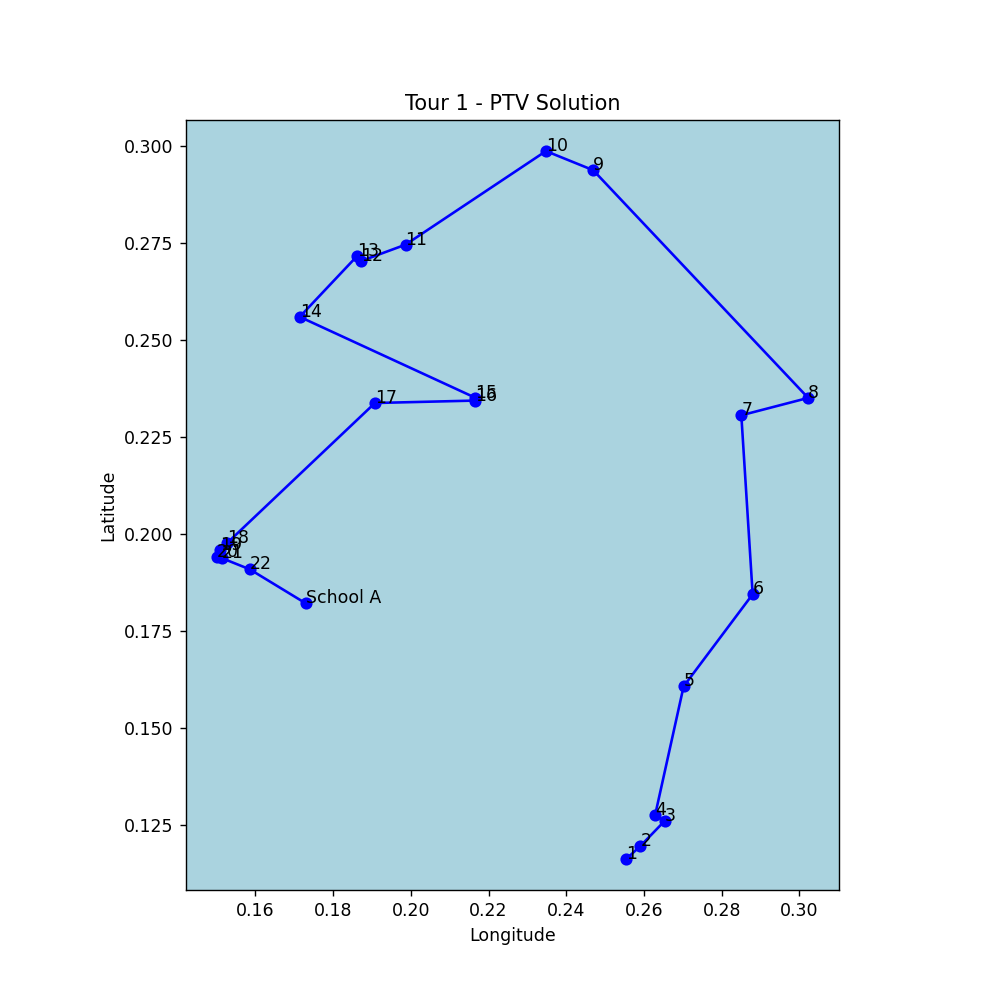

In [140]:
plot_visualization(df_create_PTV_tour1, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour1.png', 'Tour 1 - PTV Solution')

<IPython.core.display.Javascript object>


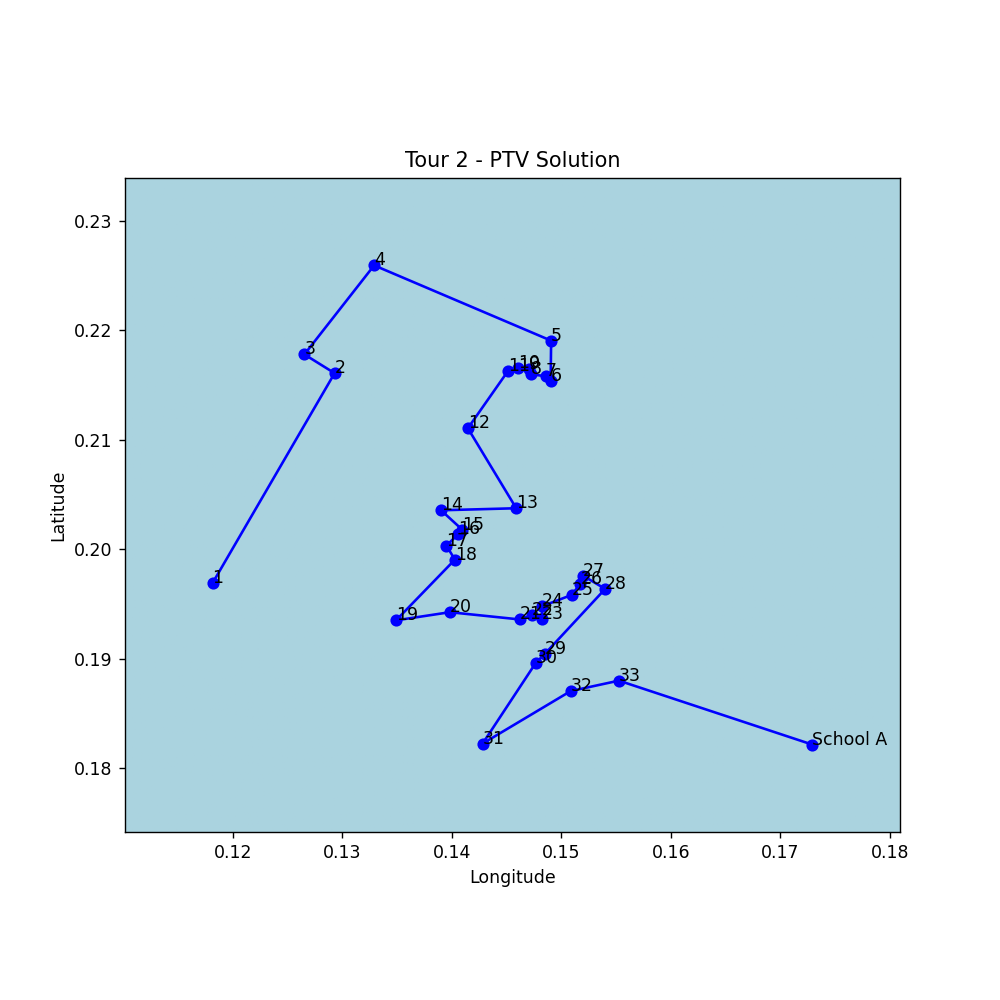

In [141]:
plot_visualization(df_create_PTV_tour2, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour2.png', 'Tour 2 - PTV Solution')

<IPython.core.display.Javascript object>


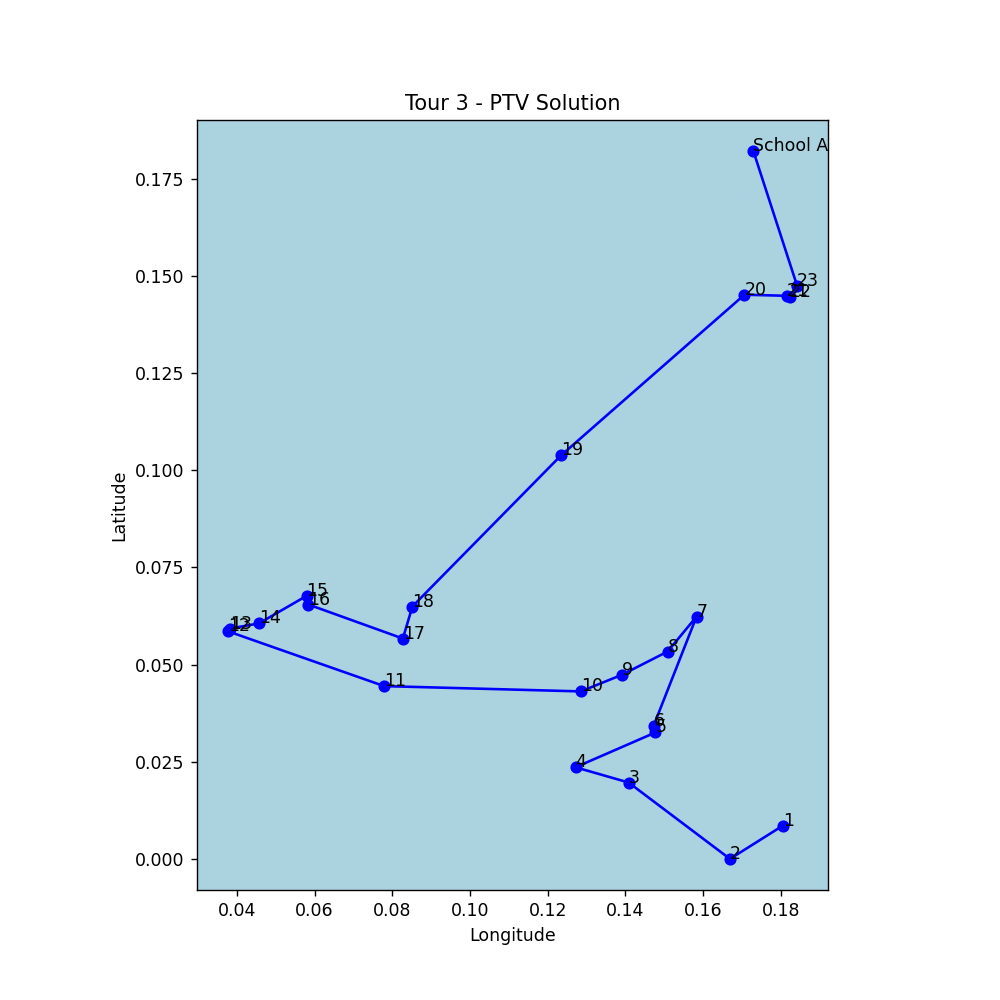

In [142]:
plot_visualization(df_create_PTV_tour3, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour3.png', 'Tour 3 - PTV Solution')

<IPython.core.display.Javascript object>


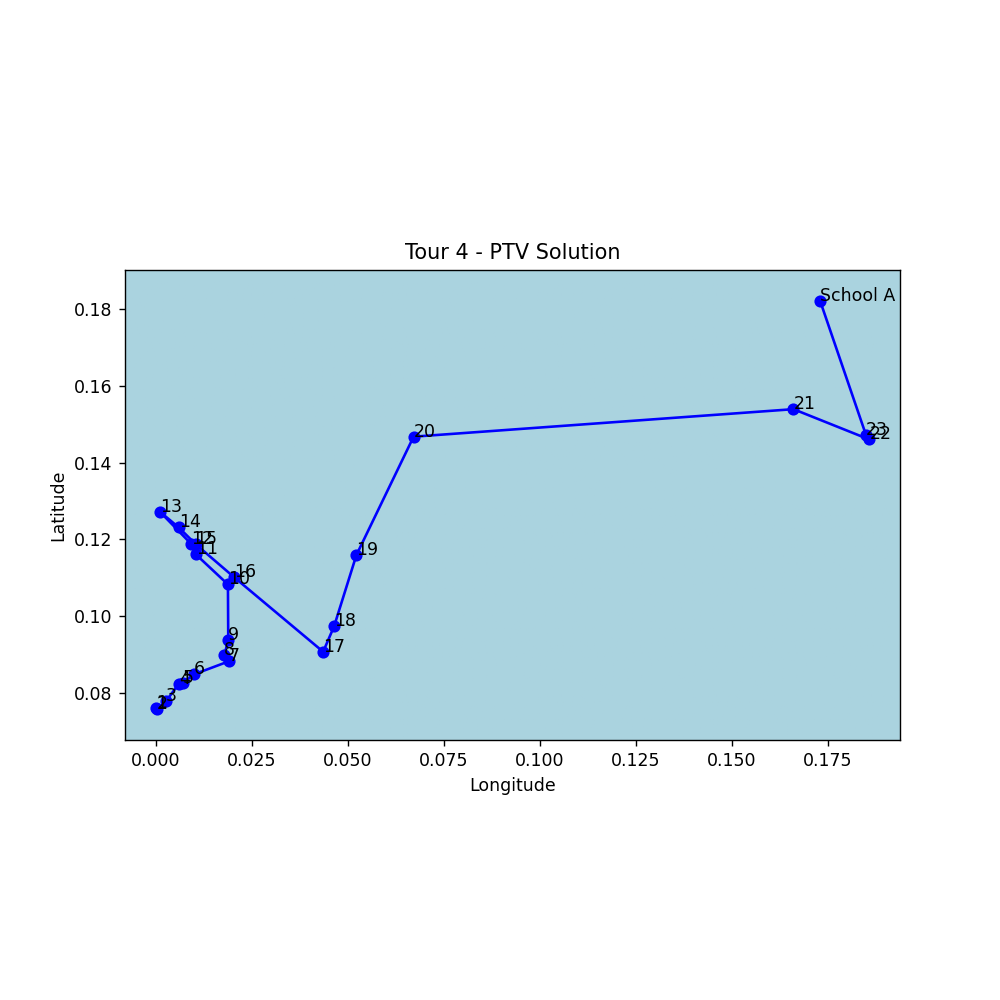

In [143]:
plot_visualization(df_create_PTV_tour4, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour4.png', 'Tour 4 - PTV Solution')

<IPython.core.display.Javascript object>


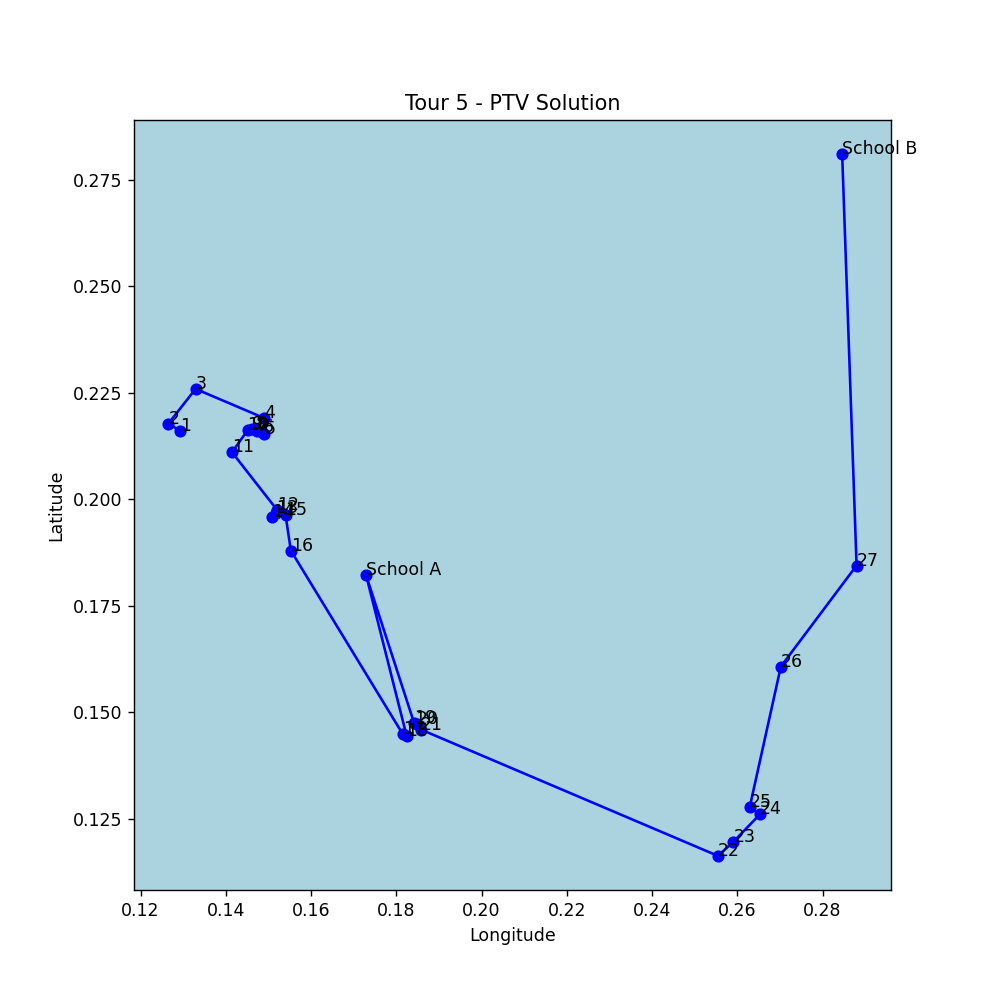

In [144]:
plot_visualization(df_create_PTV_tour5, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour5.png', 'Tour 5 - PTV Solution')

<IPython.core.display.Javascript object>


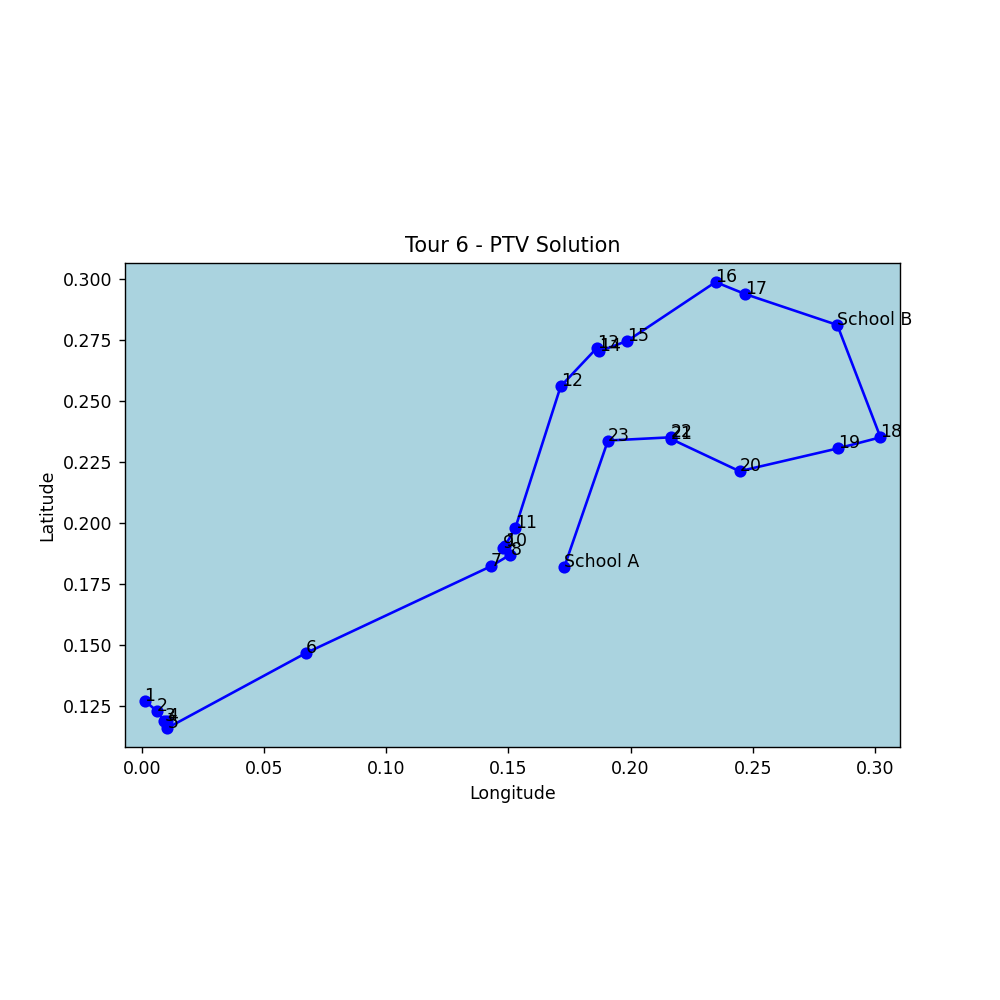

In [145]:
plot_visualization(df_create_PTV_tour6, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour6.png', 'Tour 6 - PTV Solution')

<IPython.core.display.Javascript object>


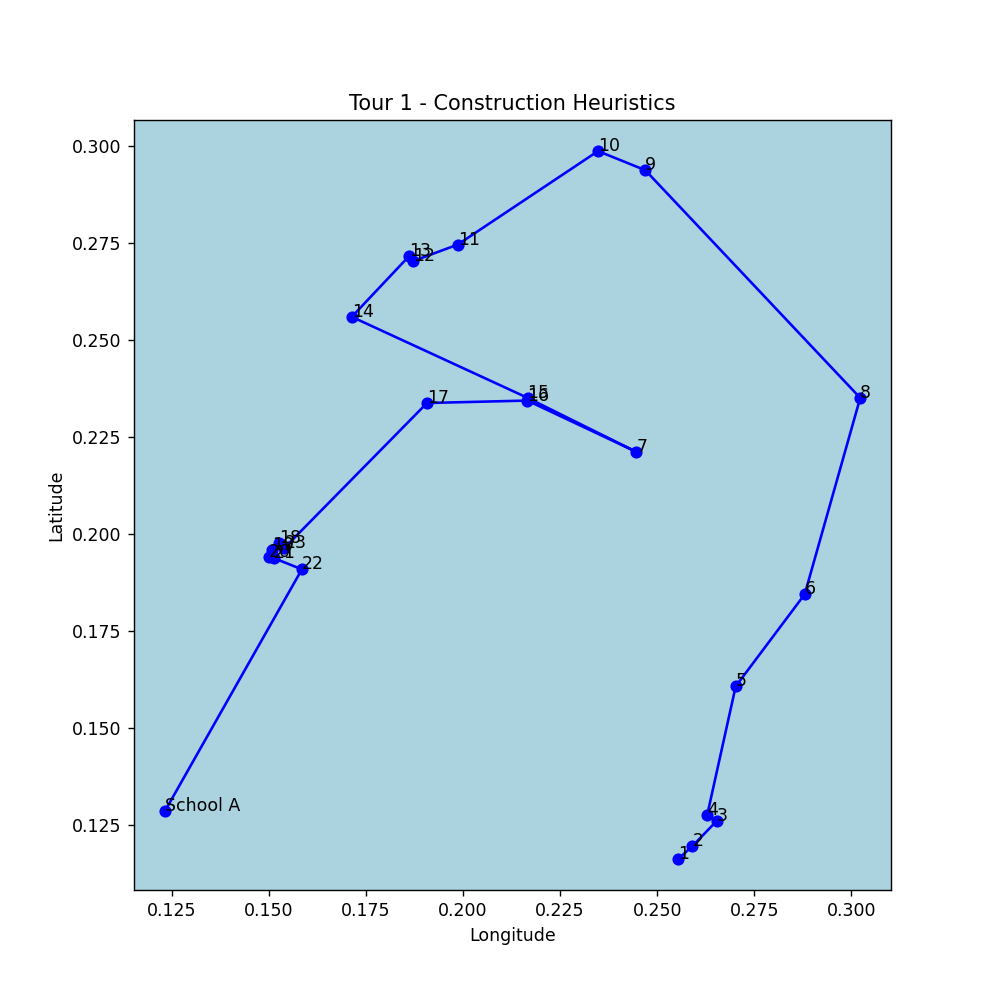

In [146]:
plot_visualization(df_create_tour1, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour1.png', 'Tour 1 - Construction Heuristics')

<IPython.core.display.Javascript object>


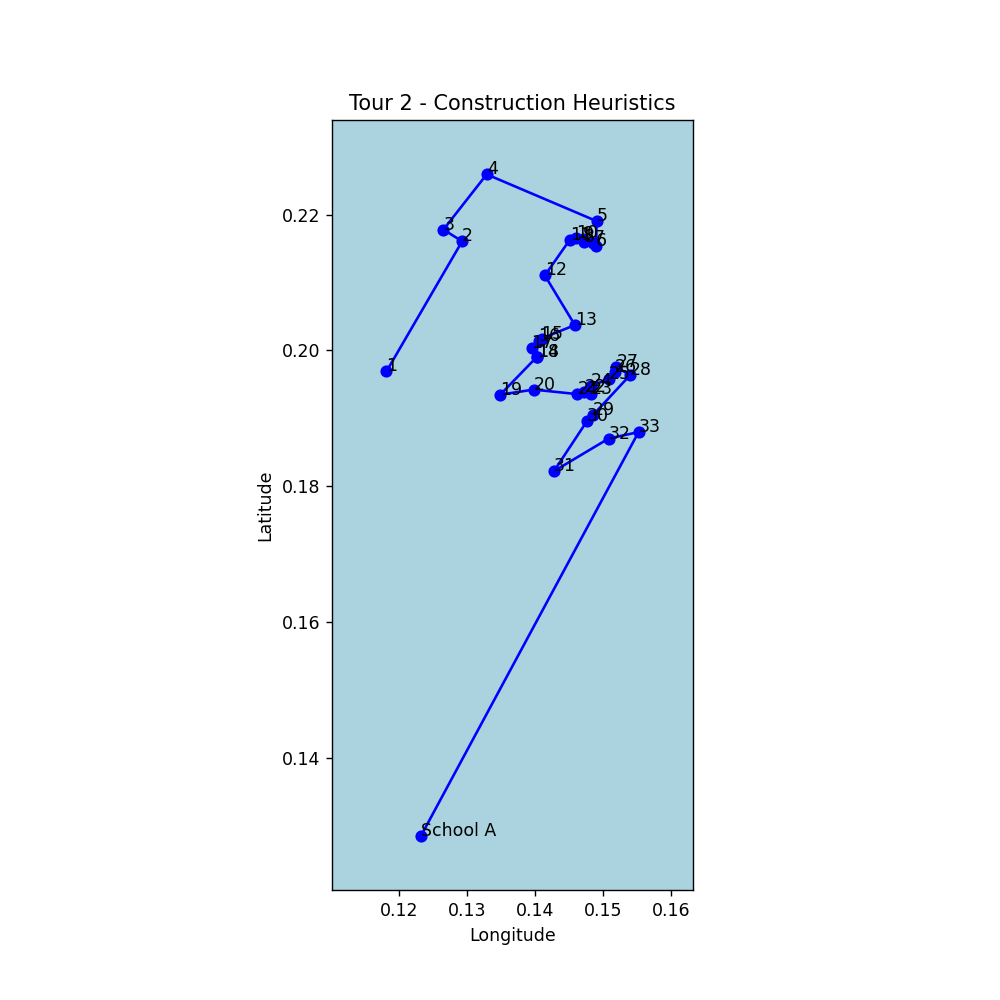

In [147]:
plot_visualization(df_create_tour2, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour2.png', 'Tour 2 - Construction Heuristics')

<IPython.core.display.Javascript object>


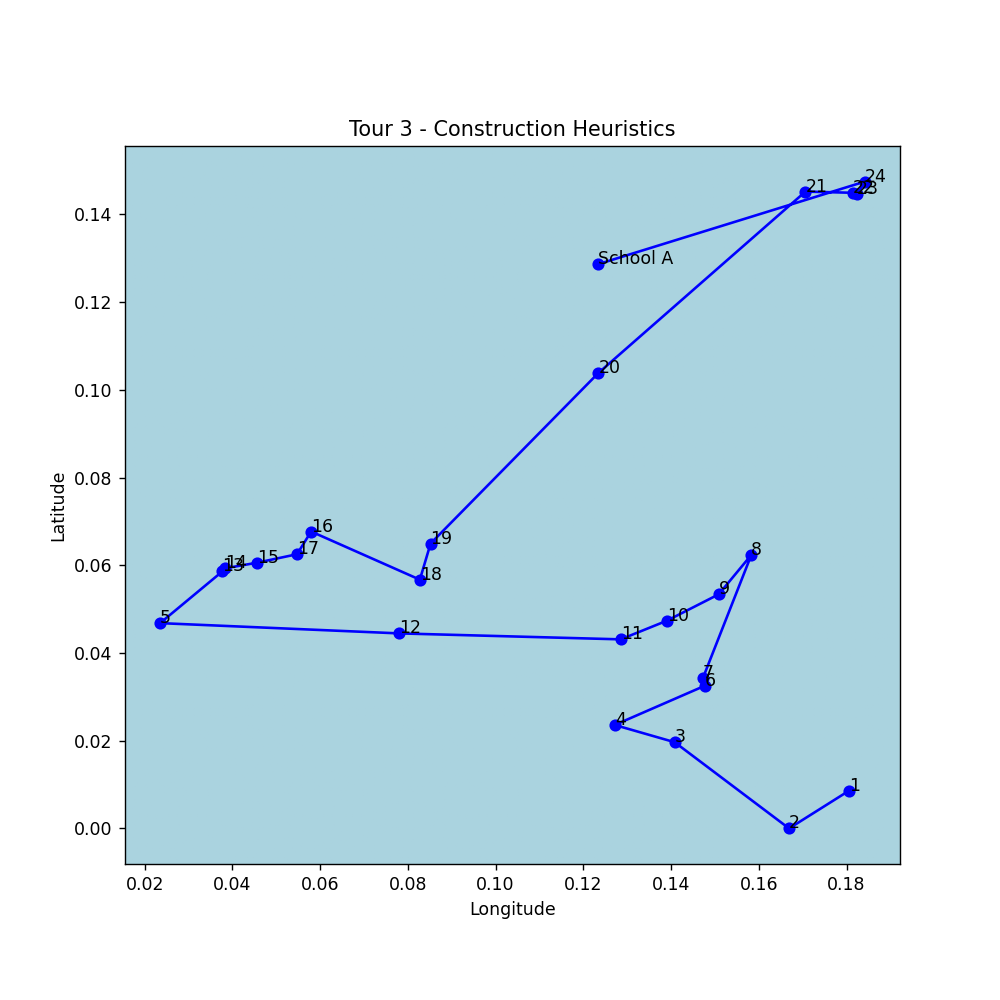

In [148]:
plot_visualization(df_create_tour3, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour3.png', 'Tour 3 - Construction Heuristics')

<IPython.core.display.Javascript object>


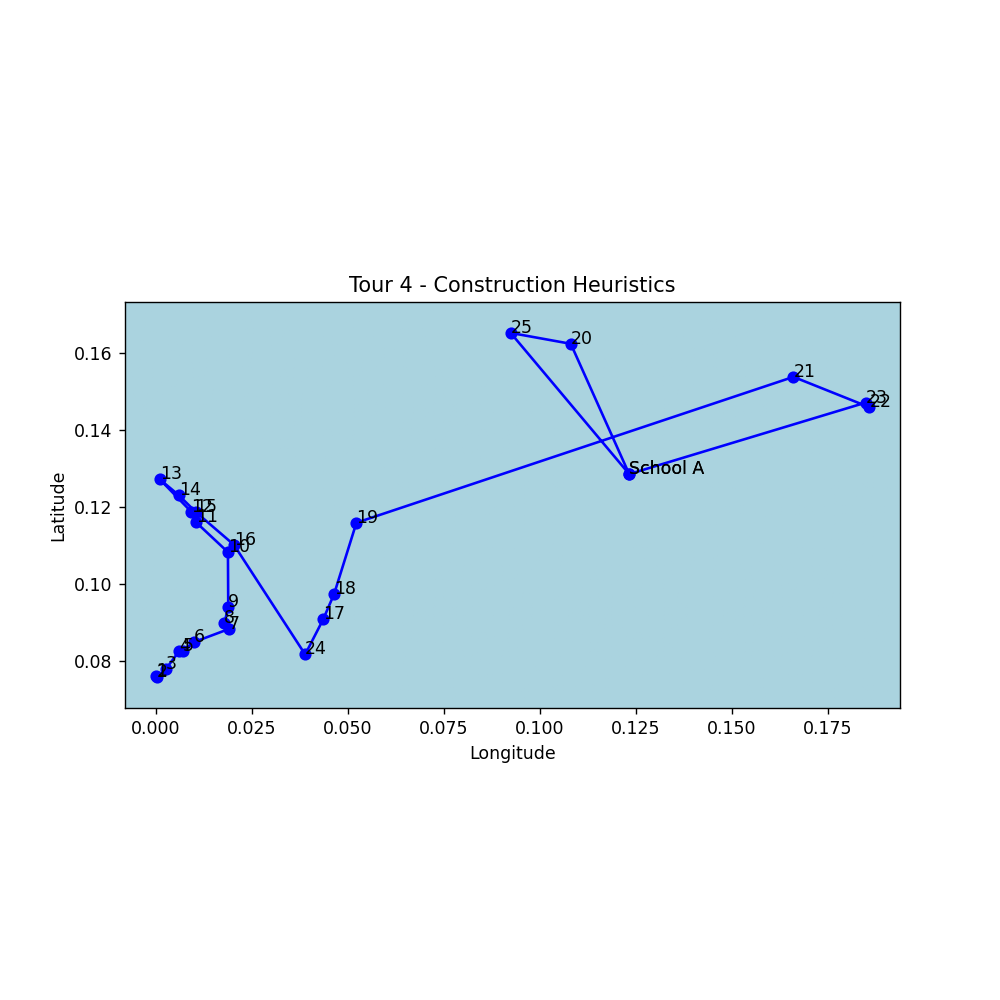

In [149]:
plot_visualization(df_create_tour4, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour4.png', 'Tour 4 - Construction Heuristics')

<IPython.core.display.Javascript object>


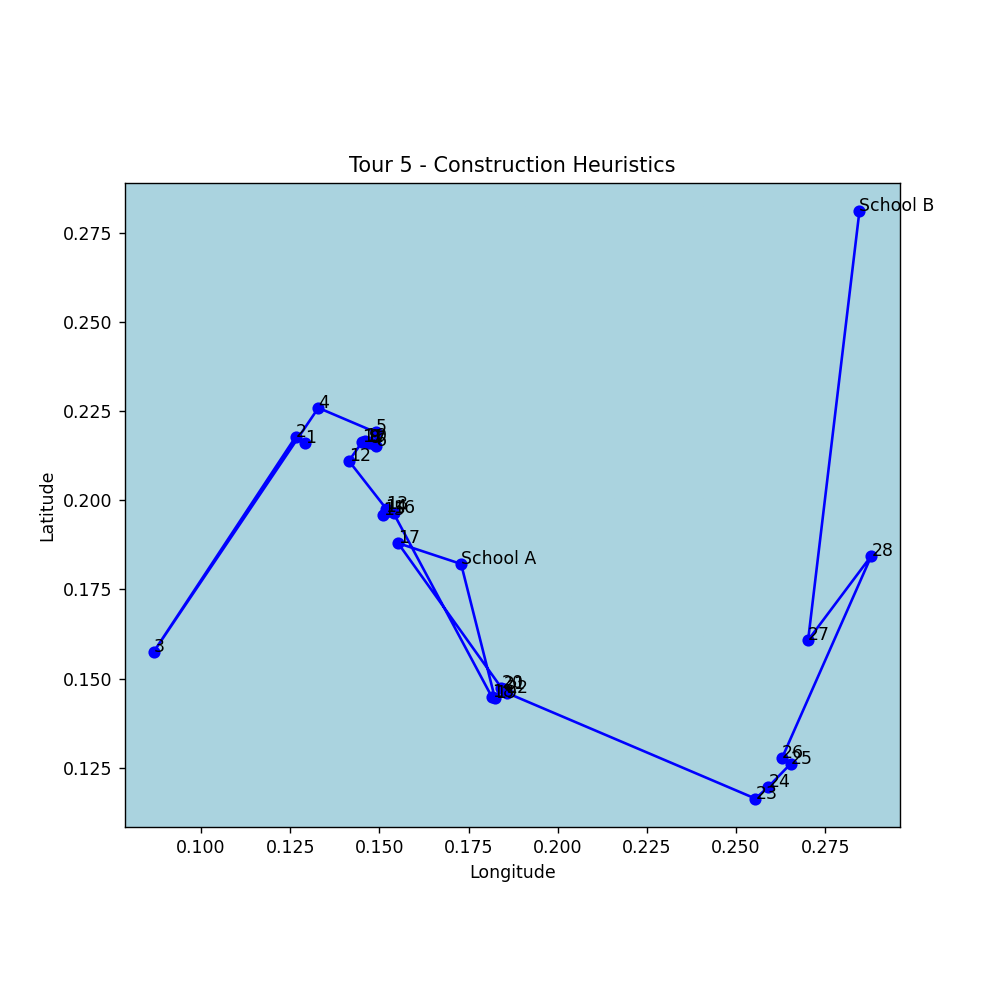

In [150]:
plot_visualization(df_create_tour5, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour5.png', 'Tour 5 - Construction Heuristics')

<IPython.core.display.Javascript object>


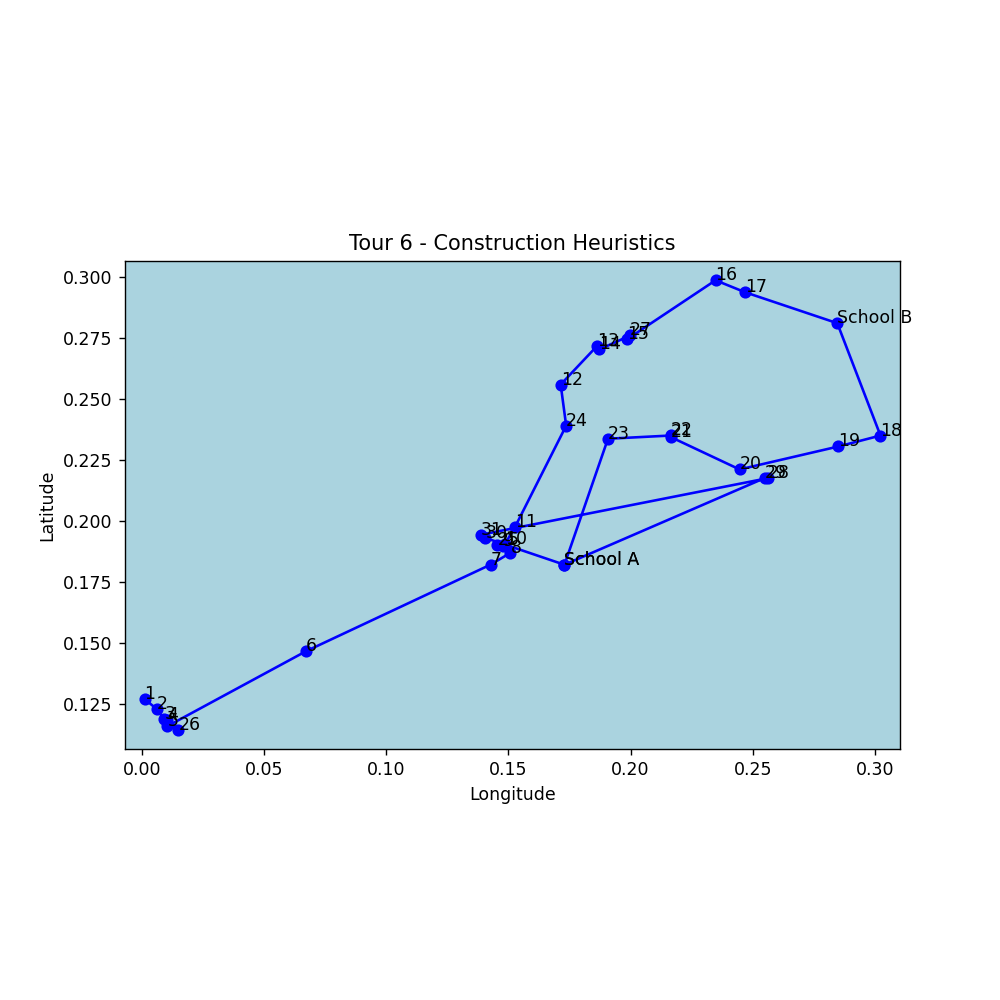

In [151]:
plot_visualization(df_create_tour6, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour6.png', 'Tour 6 - Construction Heuristics')

<IPython.core.display.Javascript object>


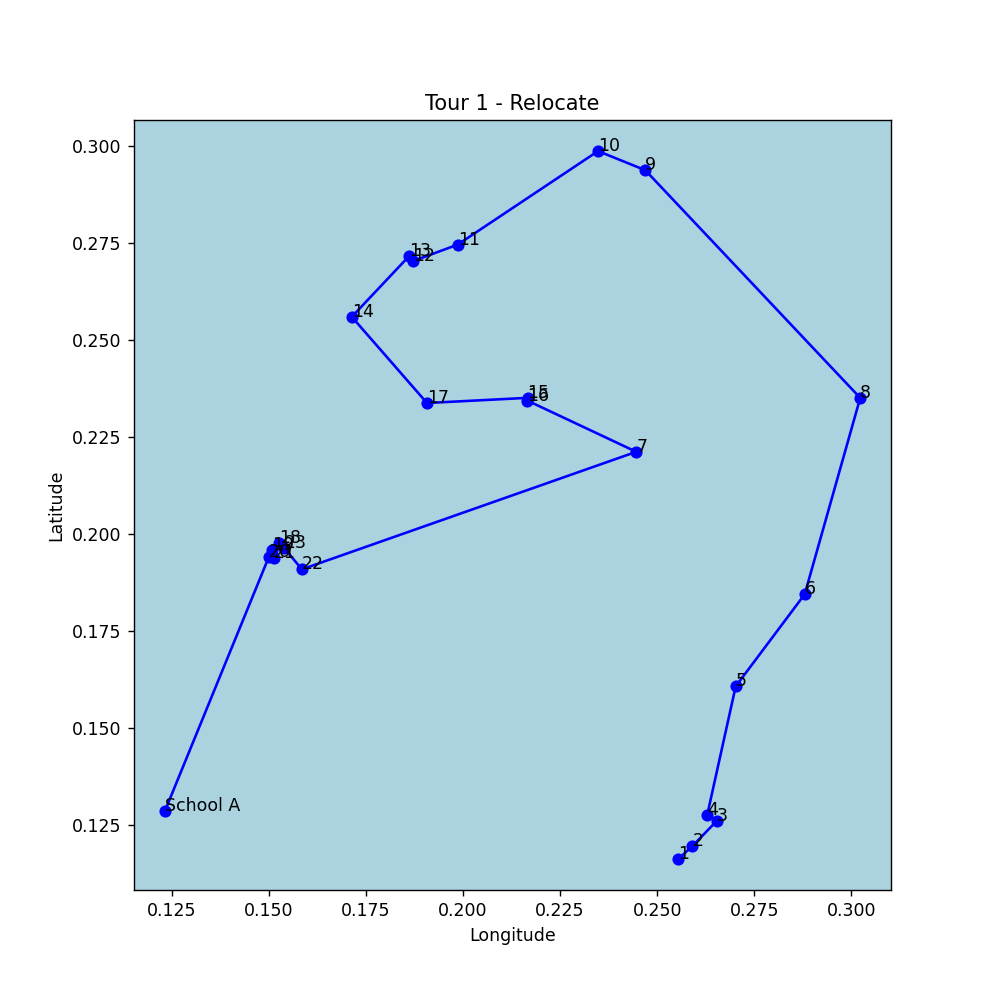

In [152]:
plot_visualization(df_create_tour1_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour1.png', 'Tour 1 - Relocate')

<IPython.core.display.Javascript object>


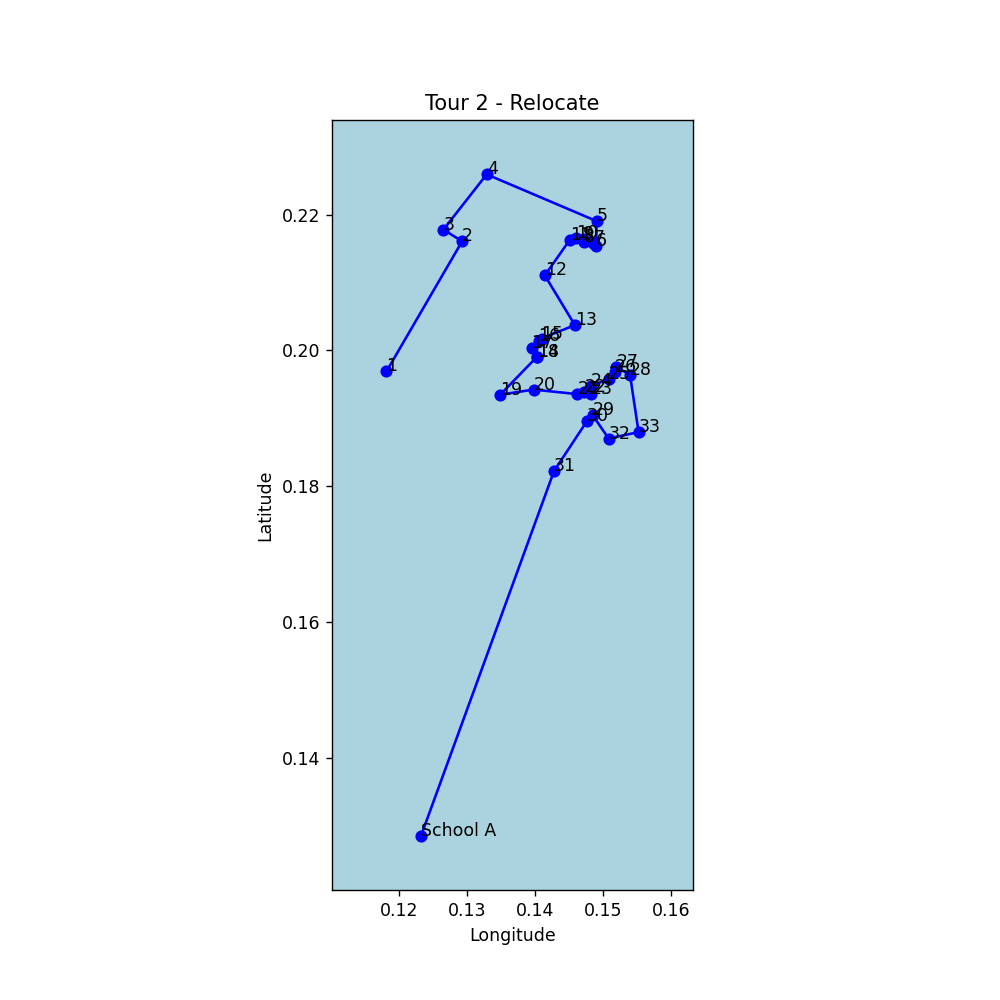

In [153]:
plot_visualization(df_create_tour2_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour2.png', 'Tour 2 - Relocate')

<IPython.core.display.Javascript object>


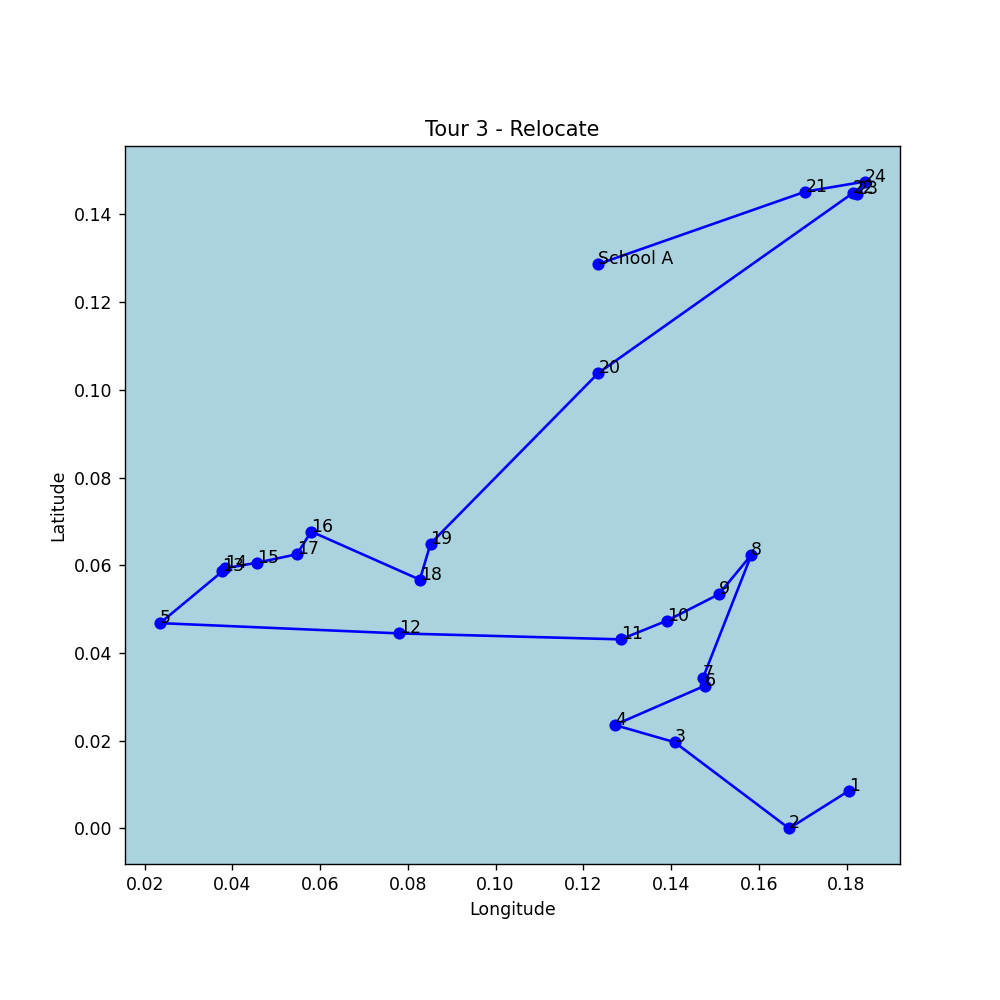

In [154]:
plot_visualization(df_create_tour3_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour3.png', 'Tour 3 - Relocate')

<IPython.core.display.Javascript object>


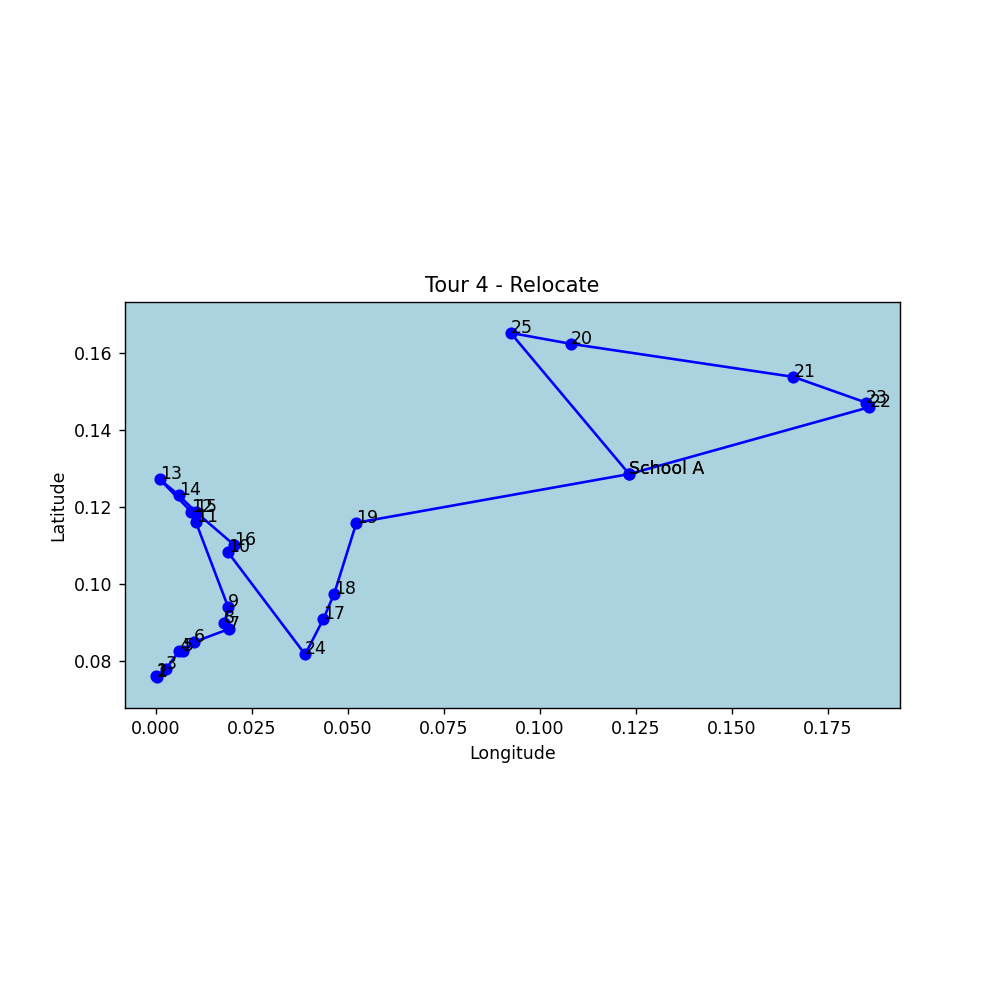

In [155]:
plot_visualization(df_create_tour4_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour4.png', 'Tour 4 - Relocate')

<IPython.core.display.Javascript object>


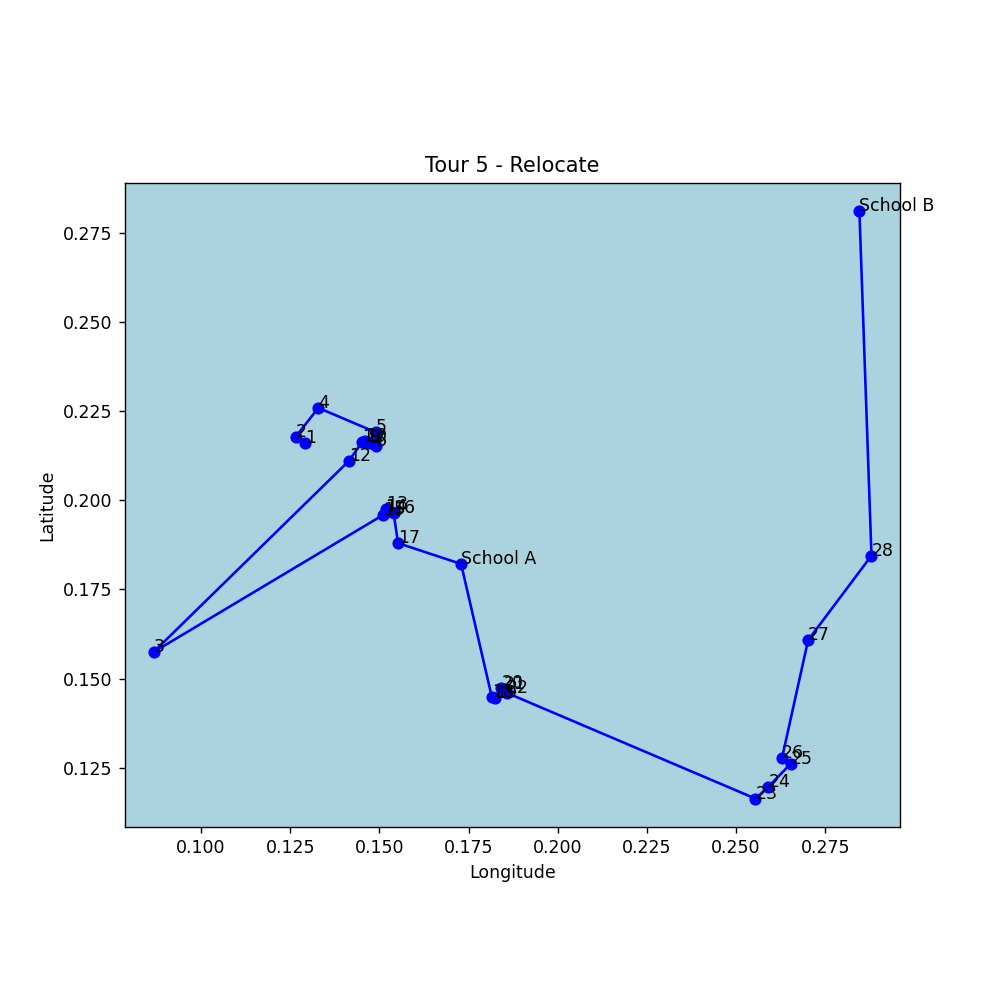

In [156]:
plot_visualization(df_create_tour5_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour5.png', 'Tour 5 - Relocate')

<IPython.core.display.Javascript object>


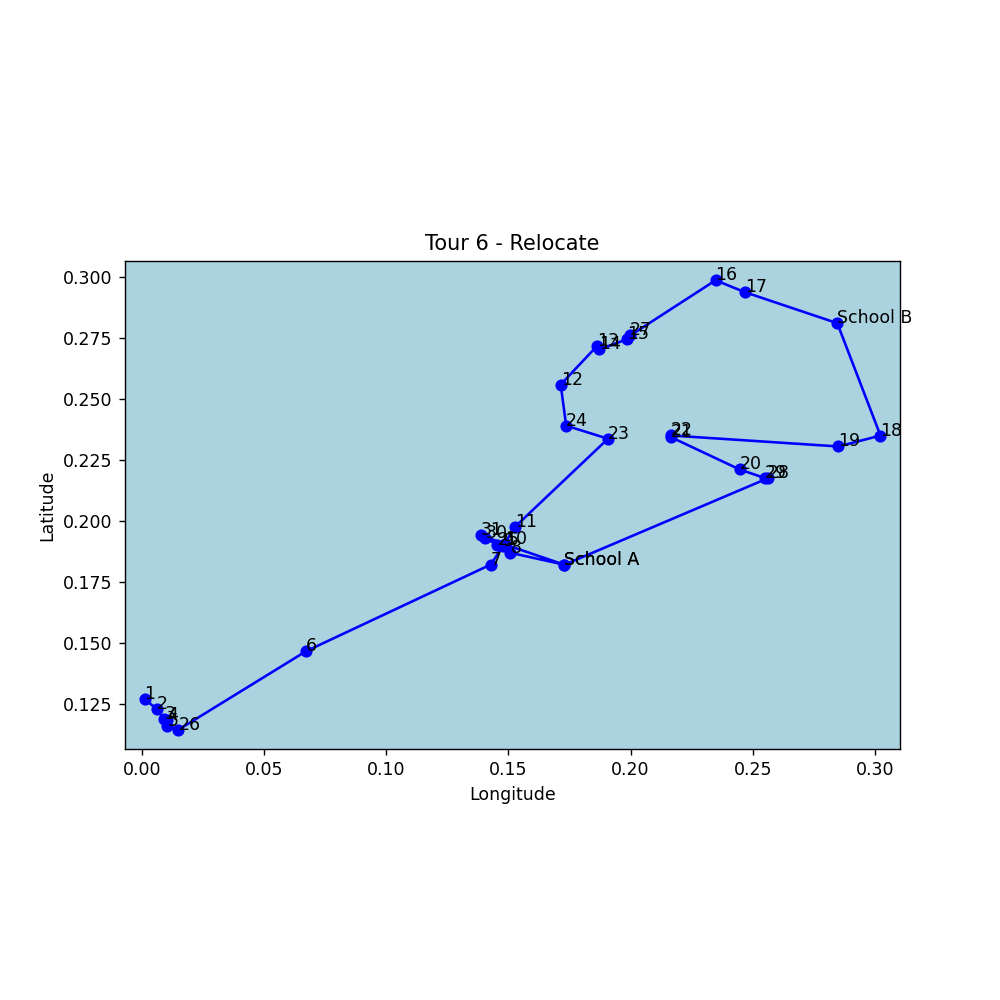

In [157]:
plot_visualization(df_create_tour6_relocate, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour6.png', 'Tour 6 - Relocate')

<IPython.core.display.Javascript object>


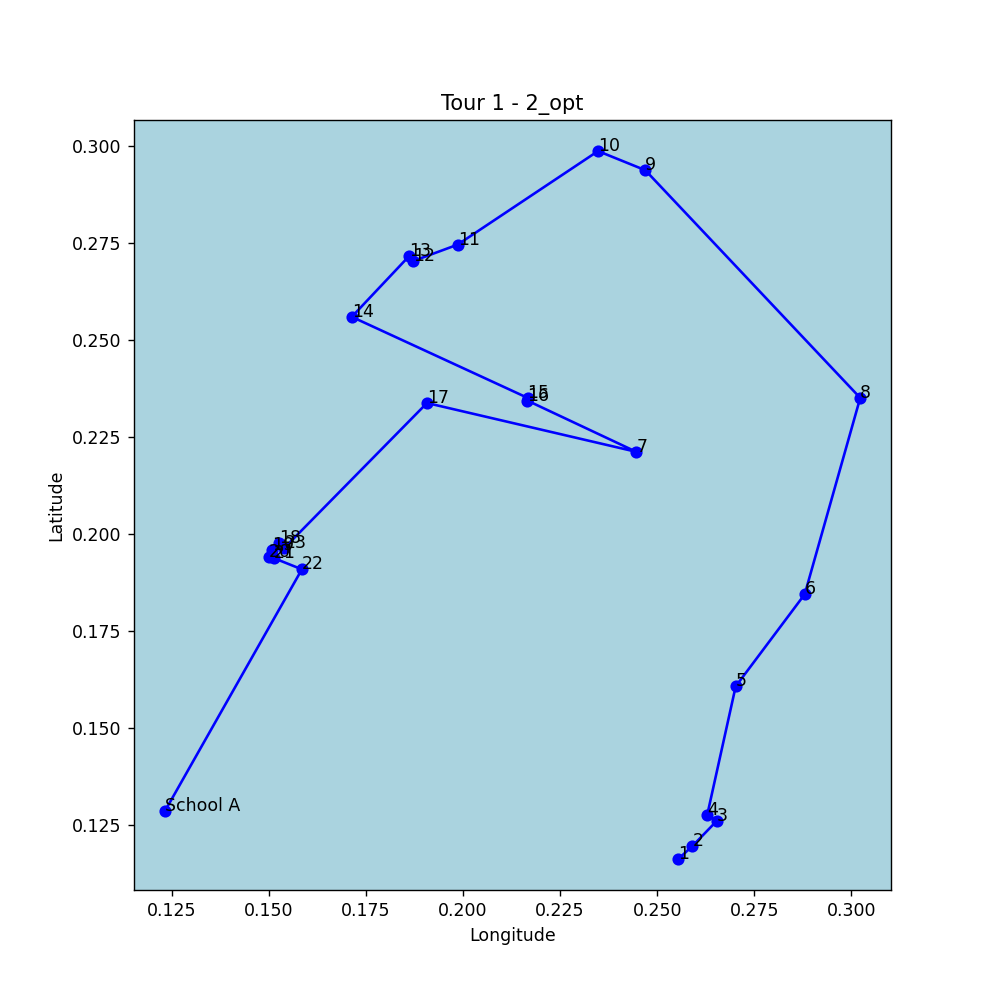

In [158]:
plot_visualization(df_create_tour1_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour1.png', 'Tour 1 - 2_opt')

<IPython.core.display.Javascript object>


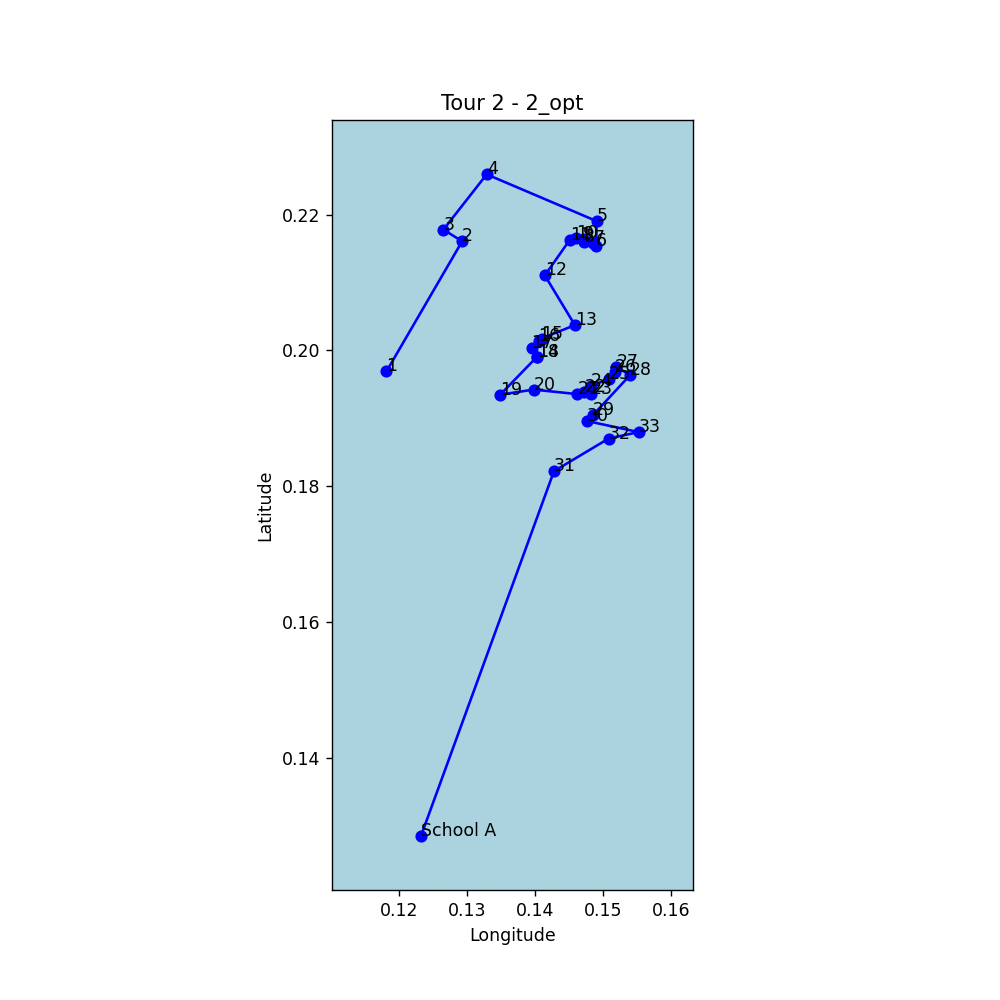

In [159]:
plot_visualization(df_create_tour2_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour2.png', 'Tour 2 - 2_opt')

<ipython-input-139-185511f7bede>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,8))


<IPython.core.display.Javascript object>


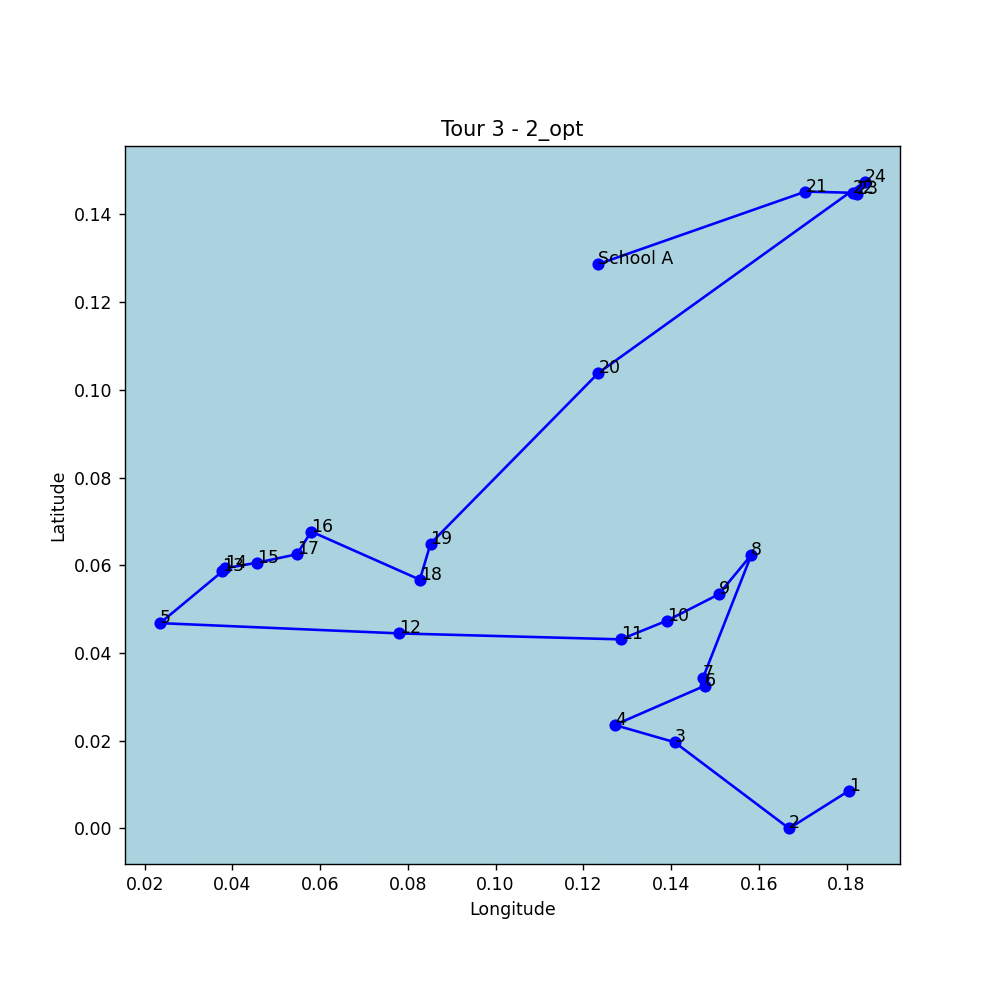

In [160]:
plot_visualization(df_create_tour3_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour3.png', 'Tour 3 - 2_opt')

<IPython.core.display.Javascript object>


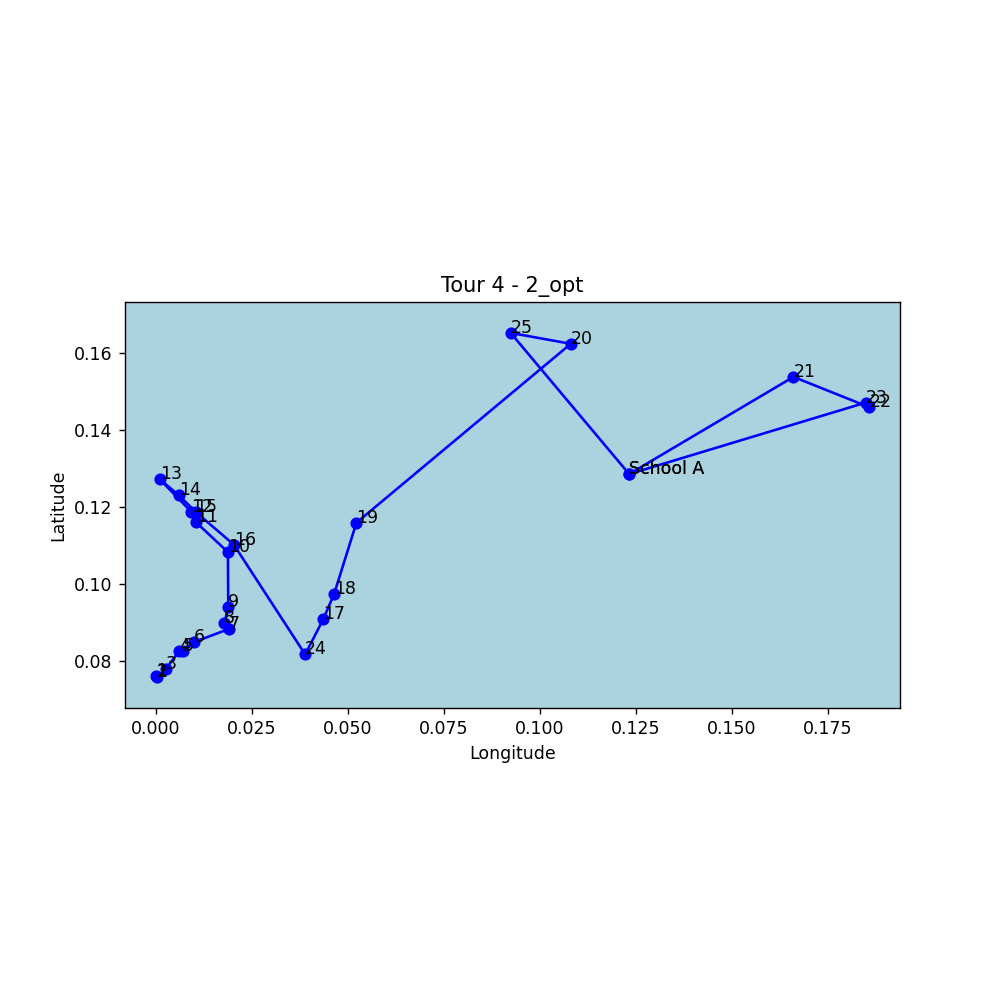

In [161]:
plot_visualization(df_create_tour4_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour4.png', 'Tour 4 - 2_opt')

<IPython.core.display.Javascript object>


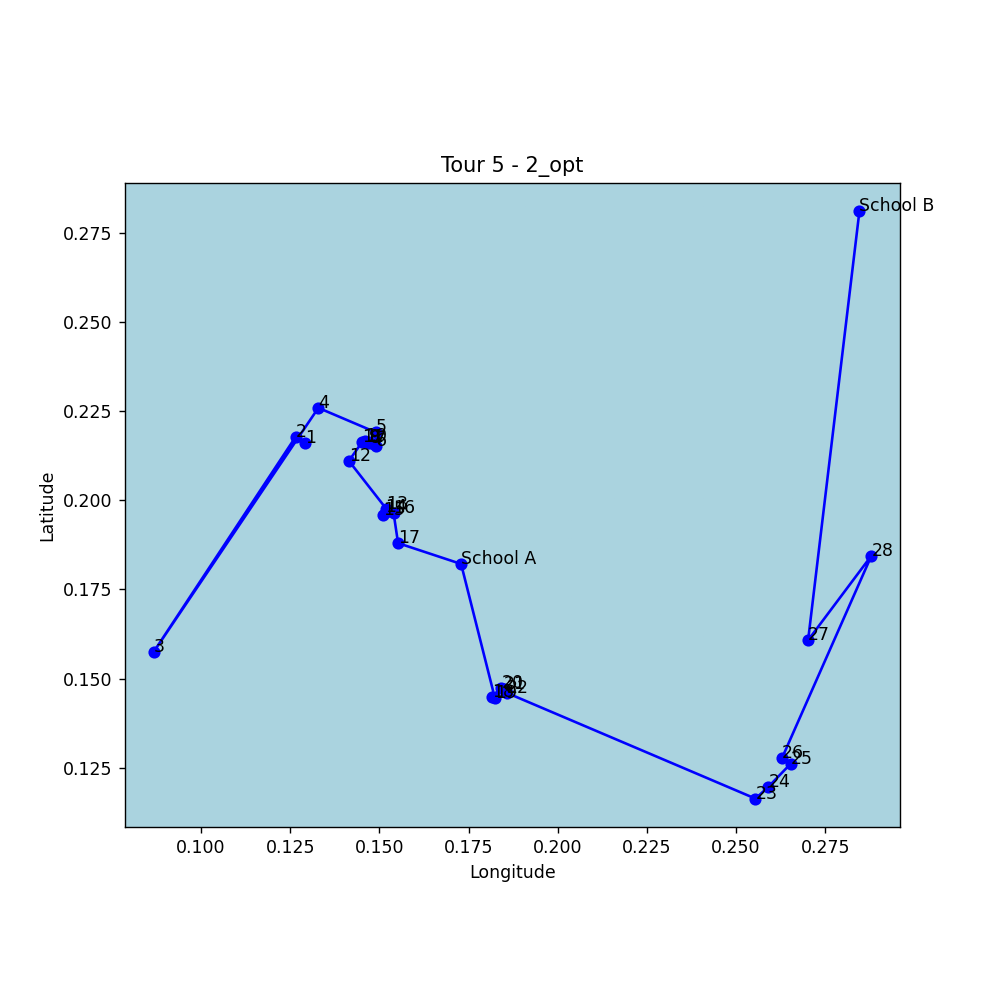

In [162]:
plot_visualization(df_create_tour5_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour5.png', 'Tour 5 - 2_opt')

<IPython.core.display.Javascript object>


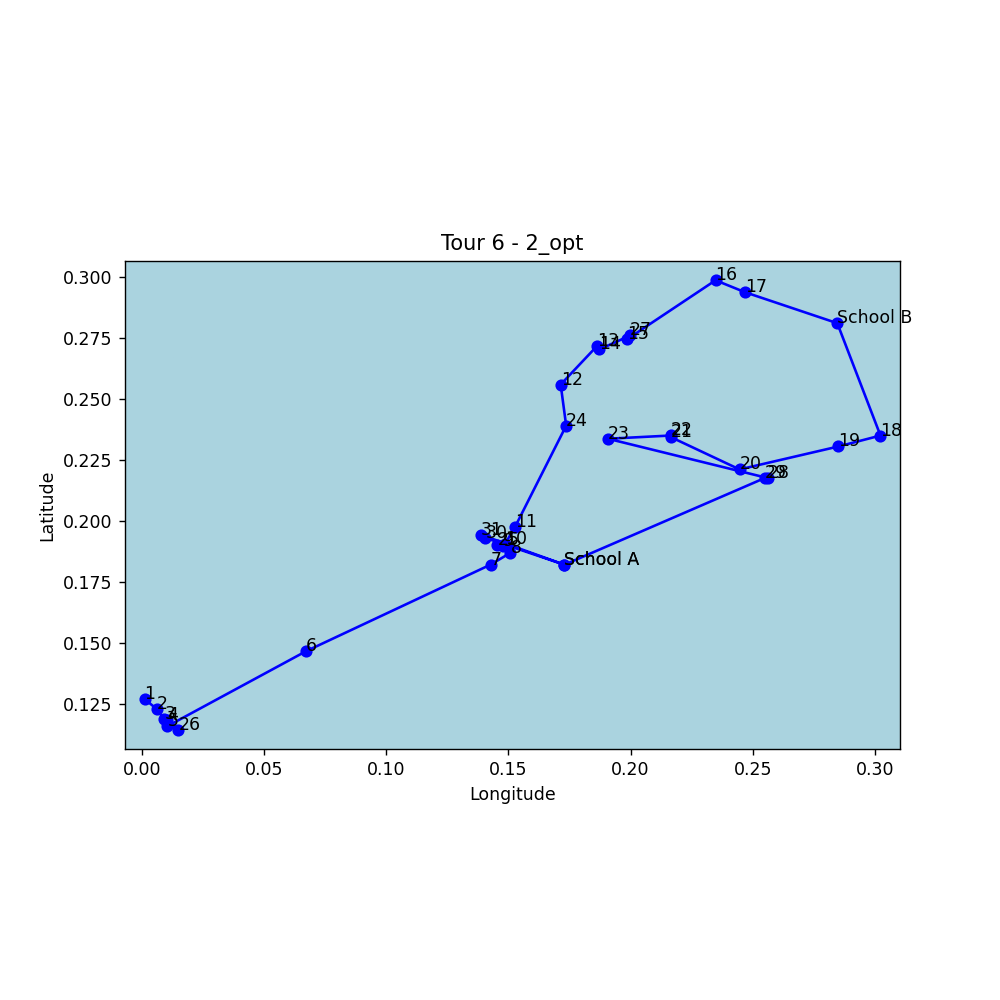

In [163]:
plot_visualization(df_create_tour6_2opt, 'D:/Analytics Project/Final/AP_PTV_Group/images/tour6.png', 'Tour 6 - 2_opt')

In [164]:
et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 14.07228970527649 seconds
